In [1]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import pandas as pd
from scipy.ndimage import gaussian_filter

from load_hyperparams import *
from masks import load_survey_masks
from satellite_realization import satellite_realization, evaluate_ln_likelihood, evaluate_ln_prior, mcmc
from load_satellites import get_true_counts

from IPython.core.debugger import set_trace

%matplotlib inline
%config InlineBackend.figure_format='retina'
%config InlineBackend.rc = {'figure.facecolor': 'w'}
#plt.rcParams['text.usetex'] = True

In [2]:
def celToGal(ra, dec):
    """
    Converts Celestial J2000 (deg) to Galactic (deg) coordinates
    """
    dec = np.radians(dec)
    sin_dec = np.sin(dec)
    cos_dec = np.cos(dec)

    ra = np.radians(ra)    
    ra_gp = np.radians(192.85948)
    de_gp = np.radians(27.12825)

    sin_ra_gp = np.sin(ra - ra_gp)
    cos_ra_gp = np.cos(ra - ra_gp)

    lcp = np.radians(122.932)    
    sin_b = (np.sin(de_gp) * sin_dec) \
            + (np.cos(de_gp) * cos_dec * cos_ra_gp)
    lcpml = np.arctan2(cos_dec * sin_ra_gp,
                          (np.cos(de_gp) * sin_dec) \
                          - (np.sin(de_gp) * cos_dec * cos_ra_gp))
    bb = np.arcsin(sin_b)
    ll = (lcp - lcpml + (2. * np.pi)) % (2. * np.pi)
    return np.degrees(ll), np.degrees(bb)

In [3]:
A0 = {}
A0['idealized'] = np.array([22.7,24.7,25.1,24.4,11.0,8.6])
A0['measured'] = np.array([22.4,25.3,31.6,21.5,9.0,4.1])
A0['measured_high_sig'] = np.array([25.0,30.8,20.7,23.4,14.3,6.5])

Mv0 = {}
Mv0['idealized'] = np.array([10.0,10.0,8.7,7.6,3.2,0.2])
Mv0['measured'] = np.array([10.0,10.0,9.9,6.6,1.9,-1.2])
Mv0['measured_high_sig'] = np.array([10.0,10.0,6.9,5.8,2.1-1.4])

logr120 = {}
logr120['idealized'] = np.array([4.0,4.3,4.7,5.0,4.4,4.7])
logr120['measured'] = np.array([3.9,4.3,4.9,4.8,4.3,3.9])
logr120['measured_high_sig'] = np.array([4.0,4.6,4.4,5.0,4.8,4.3])

def D_to_inds(D_array):
    bins = np.array([11.3, 22.6, 45.2, 90.5, 181.0, 362.0])
    return np.digitize(D_array, bins) - 1

def r12_contour(Mv, Mv0, A0, logr120):
    return A0/(Mv-Mv0) + logr120

def rubin_contour(D, Mv, scenario):
    ind = D_to_inds(D)
    return r12_contour(Mv, Mv0[scenario][ind], A0[scenario][ind], logr120[scenario][ind])

In [4]:
#Load hyperparameters
hparams, prior_hparams, cosmo_params, orphan_params, halo_data, sim_indices, vpeak_Mr_interp = load_hyperparams()

#Set parameters
params = load_params()
default_param_vector = np.array(list(load_params().values()))

In [5]:
#Load masks and ssfs
print('loading masks and ssfs ... \n')
masks,ssfs = load_survey_masks()
print('\n done')

loading masks and ssfs ... 

NSIDE = 4096
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
[18:31:21] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181168148/work/src/learner.cc:1098: Loading model from XGBoost < 1.0.0, consider saving it again for improved compatibility
[18:31:21] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181168148/work/src/learner.cc:1098: Loading model from XGBoost < 1.0.0, consider saving it again for improved compatibility


/home/kb/.conda/envs/simple/lib/python3.12/site-packages/xgboost/core.py:617: FutureWarning: Pass `objective` as keyword args.
  warnings.warn(msg, FutureWarning)
/home/kb/.conda/envs/simple/lib/python3.12/site-packages/xgboost/sklearn.py:782: UserWarning: Loading a native XGBoost model with Scikit-Learn interface.
  warnings.warn("Loading a native XGBoost model with Scikit-Learn interface.")


NSIDE = 4096
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
[18:31:22] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181168148/work/src/learner.cc:1098: Loading model from XGBoost < 1.0.0, consider saving it again for improved compatibility
[18:31:22] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181168148/work/src/learner.cc:1098: Loading model from XGBoost < 1.0.0, consider saving it again for improved compatibility

 done


In [6]:
samples = np.loadtxt('samples_DES_beta0_O1_5param_update_fgal_size_conc_2D_new_density_fixed.txt')
samples2 = np.loadtxt('samples_DES_beta0_O1_5param_update_fgal_size_conc_2D_new_density_fixed_two.txt')
samples_all = np.concatenate((samples,samples2))

samples_all[:,2] = samples_all[:,2]-np.log10(0.7)
samples_all[:,5] = 1000.*samples_all[:,5]

In [7]:
classifier = {}
names = {'idealized': 'v7_classifier.model', 'measured': 'v6_classifier.model', 
         'measured_high_sig': 'v6_corrected_classifier.model'}

for scenario in ['idealized', 'measured', 'measured_high_sig']:
    reader = open(f'../Classifier/{names[scenario]}')
    classifier[scenario] = xgb.XGBClassifier({'nthread': 4})
    classifier[scenario].load_model(names[scenario])

In [8]:
# load in the real satellite systems
real_systems = pd.read_csv('dwarf_mw.csv')
confirmed_systems = real_systems[real_systems.confirmed_real == 1]
confirmed_dwarfs = real_systems[real_systems.confirmed_dwarf == 1]
candidate_dwarfs = real_systems[(real_systems.confirmed_real == 1) & (real_systems.confirmed_dwarf == 0)]

In [9]:
#Get list of satellite realizations
combined_satellite_properties_list, mock_counts = satellite_realization(default_param_vector,
                                                           hparams,cosmo_params,orphan_params,
                                                           halo_data,sim_indices,
                                                           vpeak_Mr_interp,masks,ssfs,'cdm')

In [10]:
#First look at predictions
satellite_num = {}
satellite_num['des'] = []
satellite_num['ps1'] = []

for i in range(len(combined_satellite_properties_list)):
    for survey in ['des','ps1']:
        flags = combined_satellite_properties_list[i]['{}_flags'.format(survey)]
        satellite_num[survey].append(np.sum(combined_satellite_properties_list[i]['pdet'][flags]))

for survey in ['des','ps1']:
    print('number of predicted {} satellites = {:.1f} +/- {:.1f}'.format(survey,np.mean(satellite_num[survey],axis=0),
                                                                         np.std(satellite_num[survey],axis=0)))

number of predicted des satellites = 15.8 +/- 5.0
number of predicted ps1 satellites = 20.6 +/- 2.1


### Sample from Paper II Posterior

In [11]:
all_counts = []
all_counts_lsst = []
all_counts_lsst_subtracted = []
# all_counts_lsst_subtracted_alt = []

detected_counts_lsst = {'idealized': [], 'measured': [], 'measured_high_sig': []}
detected_counts_lsst_subtracted = {'idealized': [], 'measured': [], 'measured_high_sig': []}

for alpha, sigma_M, M50, B, sigma_mpeak, A, sigma_r, n in samples_all[np.random.randint(len(samples_all),
                                                                                           size=1000)]:
    param_vector = [alpha,sigma_M,M50,sigma_mpeak,B,A,sigma_r,n,5.5]
    combined_satellite_properties_list, mock_counts = satellite_realization(param_vector,
                                                           hparams,cosmo_params,orphan_params,
                                                           halo_data,sim_indices,
                                                           vpeak_Mr_interp,masks,ssfs,'cdm')
    ###
    for i in range(len(combined_satellite_properties_list)):
        l, b = celToGal(combined_satellite_properties_list[i]['ra'],combined_satellite_properties_list[i]['dec'])
        dec_cut = (-65.<combined_satellite_properties_list[i]['dec']) & (combined_satellite_properties_list[i]['dec']<15.)
        lsst_footprint = (np.abs(b)>20.) & (dec_cut)     # MENTION THIS HIGH GAL CUT IN PAPER
        ###
        ind = (combined_satellite_properties_list[i]['Mr']<0.)&((combined_satellite_properties_list[i]['r12']>10))
        all_counts.append(np.sum(combined_satellite_properties_list[i]['prob'][ind]))
        ###
        all_counts_lsst.append(np.sum(combined_satellite_properties_list[i]['prob'][(ind) & (lsst_footprint)]))
        ###
        not_det = combined_satellite_properties_list[i]['pdet'] < 0.5
        all_counts_lsst_subtracted.append(np.sum(combined_satellite_properties_list[i]['prob'][(ind) & (lsst_footprint) & (not_det)]))
#         all_counts_lsst_subtracted_alt.append(np.sum(((1.-combined_satellite_properties_list[i]['pdet'])*combined_satellite_properties_list[i]['prob'])[(ind) & (lsst_cut)]))
        ###
        D = combined_satellite_properties_list[i]['radii']
        Mv = combined_satellite_properties_list[i]['Mr'] + 0.2
        for scenario in ['idealized', 'measured', 'measured_high_sig']:
            lsst_det = combined_satellite_properties_list[i]['r12'] < 10.**rubin_contour(D, Mv, scenario)
            detected_counts_lsst[scenario].append(np.sum(combined_satellite_properties_list[i]['prob'][(ind) & (lsst_footprint) & (lsst_det)]))
            detected_counts_lsst_subtracted[scenario].append(np.sum(combined_satellite_properties_list[i]['prob'][(ind) & (lsst_footprint) & (lsst_det) & (not_det)]))

/tmp/ipykernel_15413/3741442455.py:34: RuntimeWarning: overflow encountered in power
  lsst_det = combined_satellite_properties_list[i]['r12'] < 10.**rubin_contour(D, Mv, scenario)


In [12]:
print(np.mean(all_counts),np.std(all_counts))
print(np.mean(all_counts_lsst),np.std(all_counts_lsst))
print(np.mean(detected_counts_lsst['idealized']),np.std(detected_counts_lsst['idealized']))
print(np.mean(detected_counts_lsst['measured']),np.std(detected_counts_lsst['measured']))
print(np.mean(detected_counts_lsst['measured_high_sig']),np.std(detected_counts_lsst['measured_high_sig']))

229.35348005477744 49.485147134458565
92.42601804161875 32.10335230472156
68.12848336367651 23.45492115869992
60.77087802131493 20.394864734140263
44.5062860497534 14.547512961455784


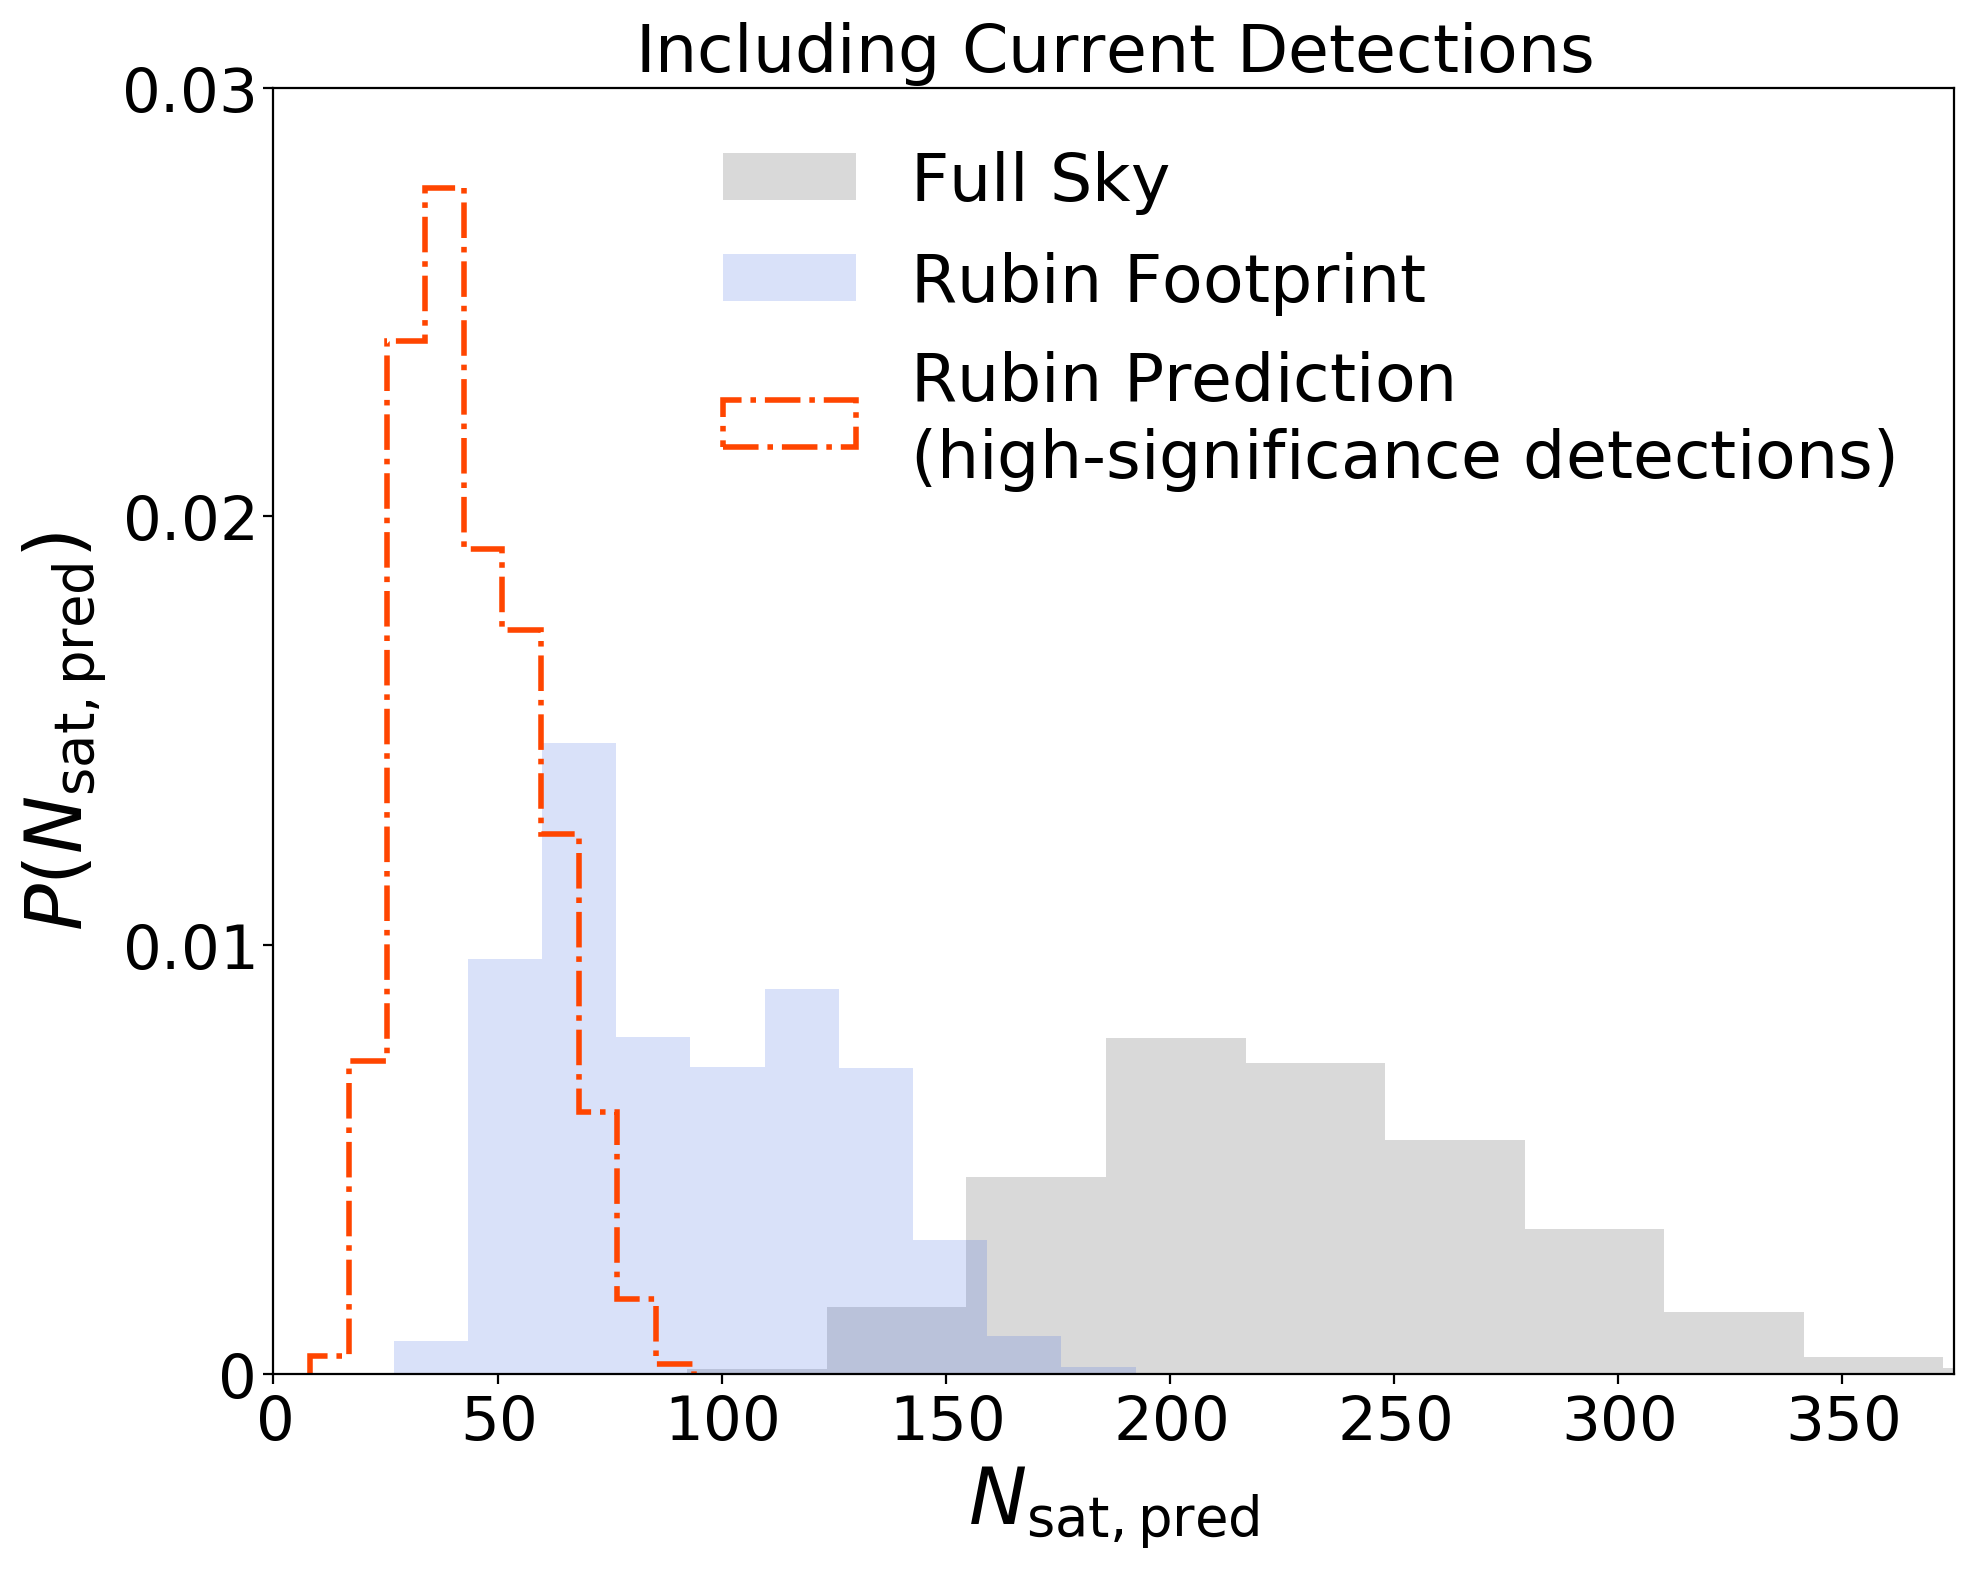

In [13]:
plt.figure(figsize=(10,8))

plt.hist(all_counts,density=True,alpha=0.15,color='k',label=r'$\mathrm{Full\ Sky}$')
plt.hist(all_counts_lsst,density=True,histtype='stepfilled',alpha=0.2,color='royalblue',label=r'$\mathrm{Rubin\ Footprint}$')
# plt.hist(detected_counts_lsst['idealized'],density=True,histtype='step',lw=2,color='orange',label=r'$\mathrm{Rubin\ Detected\ (Idealized)}$')
# plt.hist(detected_counts_lsst['measured'],density=True,histtype='step',lw=2,ls='--',color='darkorange',label=r'$\mathrm{Rubin\ Detected\ (Measured)}$')
plt.hist(detected_counts_lsst['measured_high_sig'],density=True,histtype='step',lw=2,ls='-.',color='orangered',label=r'$\mathrm{Rubin\ Prediction}$'+'\n'+r'$\mathrm{(high}$-$\mathrm{significance\ detections)}$')

plt.xlim(0,375)

plt.xticks([0,50,100,150,200,250,300,350],[r'$0$',r'$50$',r'$100$',r'$150$',r'$200$',r'$250$',
                                          r'$300$',r'$350$'],fontsize=22)
plt.yticks([0,0.01,0.02,0.03],[r'$0$',r'$0.01$',r'$0.02$',r'$0.03$',],fontsize=22)

plt.xlabel(r'$N_{\mathrm{sat,pred}}$',fontsize=28)
plt.ylabel(r'$P(N_{\mathrm{sat,pred}})$',fontsize=28)
plt.legend(loc=1,fontsize=24,frameon=False)

plt.title(r'$\mathrm{Including\ Current\ Detections}$',fontsize=24)

plt.tight_layout()
plt.show()

In [14]:
print(np.mean(all_counts),np.std(all_counts))
print(np.mean(all_counts_lsst_subtracted),np.std(all_counts_lsst_subtracted))
print(np.mean(detected_counts_lsst_subtracted['idealized']),np.std(detected_counts_lsst_subtracted['idealized']))
print(np.mean(detected_counts_lsst_subtracted['measured']),np.std(detected_counts_lsst_subtracted['measured']))
print(np.mean(detected_counts_lsst_subtracted['measured_high_sig']),np.std(detected_counts_lsst_subtracted['measured_high_sig']))

229.35348005477744 49.485147134458565
76.61399756963799 28.328124268874305
52.359892167846134 19.1364247635344
45.064769543609195 16.114571510824124
29.035164361585775 10.35456539855795


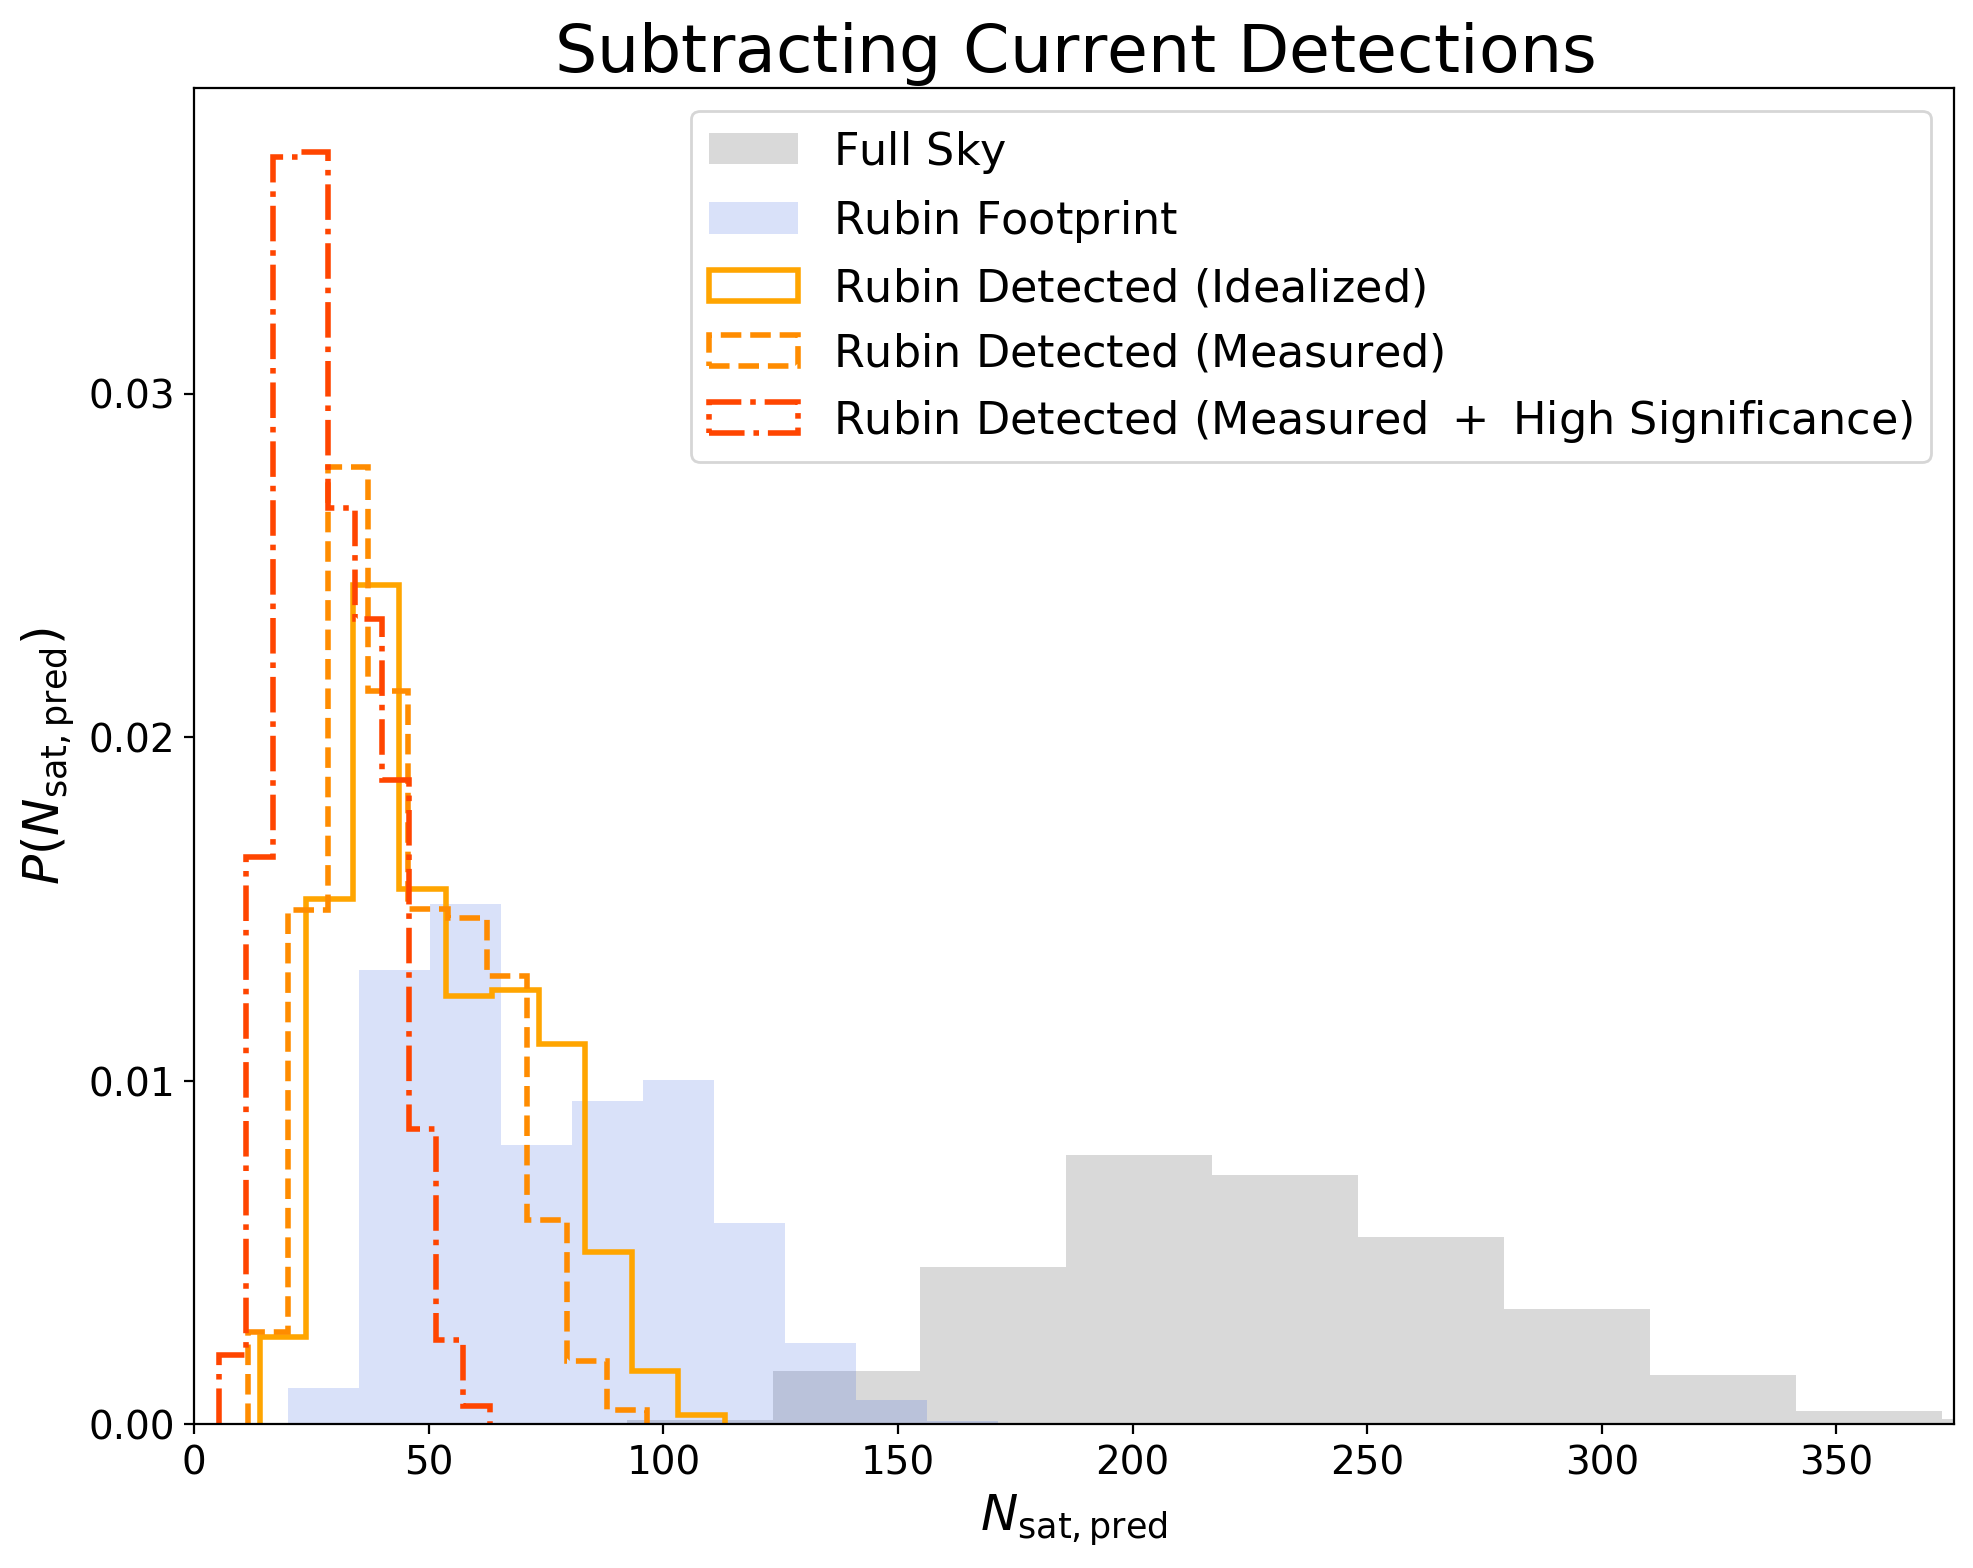

In [15]:
plt.figure(figsize=(10,8))

plt.hist(all_counts,density=True,alpha=0.15,color='k',label=r'$\mathrm{Full\ Sky}$')
plt.hist(all_counts_lsst_subtracted,density=True,histtype='stepfilled',alpha=0.2,color='royalblue',label=r'$\mathrm{Rubin\ Footprint}$')
plt.hist(detected_counts_lsst_subtracted['idealized'],density=True,histtype='step',lw=2,color='orange',label=r'$\mathrm{Rubin\ Detected\ (Idealized)}$')
plt.hist(detected_counts_lsst_subtracted['measured'],density=True,histtype='step',lw=2,ls='--',color='darkorange',label=r'$\mathrm{Rubin\ Detected\ (Measured)}$')
plt.hist(detected_counts_lsst_subtracted['measured_high_sig'],density=True,histtype='step',lw=2,ls='-.',color='orangered',label=r'$\mathrm{Rubin\ Detected\ (Measured\ +\ High\ Significance)}$')

plt.xlim(0,375)

plt.xticks([0,50,100,150,200,250,300,350],fontsize=14)
plt.yticks([0,0.01,0.02,0.03],fontsize=14)

plt.xlabel(r'$N_{\mathrm{sat,pred}}$',fontsize=18)
plt.ylabel(r'$P(N_{\mathrm{sat,pred}})$',fontsize=18)
plt.legend(loc=1,fontsize=16)

plt.title(r'$\mathrm{Subtracting\ Current\ Detections}$',fontsize=24)

plt.tight_layout()
plt.show()

### New Survey Selection Function

In [16]:
classifier = {}
names = {'idealized': 'v7_classifier.model', 'measured': 'v6_classifier.model', 
         'measured_high_sig': 'v6_corrected_classifier.model'}

for scenario in ['idealized', 'measured', 'measured_high_sig']:
    print(scenario)
    reader = open(names[scenario])
    classifier[scenario] = xgb.XGBClassifier({'nthread': 4})
    classifier[scenario].load_model(names[scenario])

    #KB code snippet
    # ssf.load_classifier('v6_classifier.model')                       # load classifier
    size = 1                                                         # number of satellites
    distance = np.random.uniform(8, 16, size)                        # kpc
    abs_mag = np.random.uniform(-10, 2.5, size)                      # mag
    r_physical = np.logspace(-0.5, 3, size)                          # pc
    x_eval = np.vstack([abs_mag, np.log10(r_physical), distance]).T
    pdet = classifier[scenario].predict_proba(x_eval)[:,1]
    print(pdet)   

idealized
[0.998379]
measured
[0.9848371]
measured_high_sig
[0.97659427]


/home/kb/.conda/envs/simple/lib/python3.12/site-packages/xgboost/core.py:617: FutureWarning: Pass `objective` as keyword args.
  warnings.warn(msg, FutureWarning)


In [17]:
all_counts = []
all_counts_lsst = []
all_counts_lsst_subtracted = []
# all_counts_lsst_subtracted_alt = []

detected_counts_lsst = {'idealized': [], 'measured': [], 'measured_high_sig': []}
detected_counts_lsst_subtracted = {'idealized': [], 'measured': [], 'measured_high_sig': []}

for alpha, sigma_M, M50, B, sigma_mpeak, A, sigma_r, n in samples_all[np.random.randint(len(samples_all),
                                                                                           size=1000)]:
    param_vector = [alpha,sigma_M,M50,sigma_mpeak,B,A,sigma_r,n,5.5]
    combined_satellite_properties_list, mock_counts = satellite_realization(param_vector,
                                                           hparams,cosmo_params,orphan_params,
                                                           halo_data,sim_indices,
                                                           vpeak_Mr_interp,masks,ssfs,'cdm')
    ###
    for i in range(len(combined_satellite_properties_list)):
        l, b = celToGal(combined_satellite_properties_list[i]['ra'],combined_satellite_properties_list[i]['dec'])
        dec_cut = (-65.<combined_satellite_properties_list[i]['dec']) & (combined_satellite_properties_list[i]['dec']<15.)
        lsst_footprint = (np.abs(b)>20.) & (dec_cut)
        ###
        ind = (combined_satellite_properties_list[i]['Mr']<0.)&((combined_satellite_properties_list[i]['r12']>10))
        all_counts.append(np.sum(combined_satellite_properties_list[i]['prob'][ind]))
        ###
        all_counts_lsst.append(np.sum(combined_satellite_properties_list[i]['prob'][(ind) & (lsst_footprint)]))
        ###
        not_det = combined_satellite_properties_list[i]['pdet'] < 0.5
        all_counts_lsst_subtracted.append(np.sum(combined_satellite_properties_list[i]['prob'][(ind) & (lsst_footprint) & (not_det)]))
#         all_counts_lsst_subtracted_alt.append(np.sum(((1.-combined_satellite_properties_list[i]['pdet'])*combined_satellite_properties_list[i]['prob'])[(ind) & (lsst_cut)]))
        ###
        D = combined_satellite_properties_list[i]['radii']
        Mv = combined_satellite_properties_list[i]['Mr'] + 0.2
        r12 = combined_satellite_properties_list[i]['r12']
        for scenario in ['idealized', 'measured', 'measured_high_sig']:
            x_eval = np.vstack([Mv, np.log10(r12), D]).T
            pdet = classifier[scenario].predict_proba(x_eval)[:,1]
#             lsst_det = combined_satellite_properties_list[i]['r12'] < 10.**rubin_contour(D, Mv, scenario)
            detected_counts_lsst[scenario].append(np.sum((combined_satellite_properties_list[i]['prob']*pdet)[(ind) & (lsst_footprint)]))
            detected_counts_lsst_subtracted[scenario].append(np.sum((combined_satellite_properties_list[i]['prob']*pdet)[(ind) & (lsst_footprint) & (not_det)]))
        
        

In [18]:
print(np.mean(all_counts),np.std(all_counts))
print(np.mean(all_counts_lsst),np.std(all_counts_lsst))
print(np.mean(detected_counts_lsst['idealized']),np.std(detected_counts_lsst['idealized']))
print(np.mean(detected_counts_lsst['measured']),np.std(detected_counts_lsst['measured']))
print(np.mean(detected_counts_lsst['measured_high_sig']),np.std(detected_counts_lsst['measured_high_sig']))

231.11433895070735 48.96969021984666
93.05573743098613 32.01413211675257
64.12619984625294 20.519376733214713
61.21718044217995 19.150402006643727
44.81437974590464 13.380684780871698


### Keep only $r_{1/2}>10~\mathrm{pc}$ cut

In [19]:
all_counts = []
all_counts_lsst = []
all_counts_lsst_subtracted = []
# all_counts_lsst_subtracted_alt = []

detected_counts_lsst = {'idealized': [], 'measured': [], 'measured_high_sig': []}
detected_counts_lsst_subtracted = {'idealized': [], 'measured': [], 'measured_high_sig': []}

for alpha, sigma_M, M50, B, sigma_mpeak, A, sigma_r, n in samples_all[np.random.randint(len(samples_all),
                                                                                           size=1000)]:
    param_vector = [alpha,sigma_M,M50,sigma_mpeak,B,A,sigma_r,n,5.5]
    combined_satellite_properties_list, mock_counts = satellite_realization(param_vector,
                                                           hparams,cosmo_params,orphan_params,
                                                           halo_data,sim_indices,
                                                           vpeak_Mr_interp,masks,ssfs,'cdm')
    ###
    for i in range(len(combined_satellite_properties_list)):
        l, b = celToGal(combined_satellite_properties_list[i]['ra'],combined_satellite_properties_list[i]['dec'])
        dec_cut = (-65.<combined_satellite_properties_list[i]['dec']) & (combined_satellite_properties_list[i]['dec']<15.)
        lsst_footprint = (np.abs(b)>20.) & (dec_cut)
        ###
        ind = (combined_satellite_properties_list[i]['r12']>10)
        all_counts.append(np.sum(combined_satellite_properties_list[i]['prob'][ind]))
        ###
        all_counts_lsst.append(np.sum(combined_satellite_properties_list[i]['prob'][(ind) & (lsst_footprint)]))
        ###
        not_det = combined_satellite_properties_list[i]['pdet'] < 0.5
        all_counts_lsst_subtracted.append(np.sum(combined_satellite_properties_list[i]['prob'][(ind) & (lsst_footprint) & (not_det)]))
#         all_counts_lsst_subtracted_alt.append(np.sum(((1.-combined_satellite_properties_list[i]['pdet'])*combined_satellite_properties_list[i]['prob'])[(ind) & (lsst_cut)]))
        ###
        D = combined_satellite_properties_list[i]['radii']
        Mv = combined_satellite_properties_list[i]['Mr'] + 0.2
        r12 = combined_satellite_properties_list[i]['r12']
        for scenario in ['idealized', 'measured', 'measured_high_sig']:
            x_eval = np.vstack([Mv, np.log10(r12), D]).T
            pdet = classifier[scenario].predict_proba(x_eval)[:,1]
#             lsst_det = combined_satellite_properties_list[i]['r12'] < 10.**rubin_contour(D, Mv, scenario)
            detected_counts_lsst[scenario].append(np.sum((combined_satellite_properties_list[i]['prob']*pdet)[(ind) & (lsst_footprint)]))
            detected_counts_lsst_subtracted[scenario].append(np.sum((combined_satellite_properties_list[i]['prob']*pdet)[(ind) & (lsst_footprint) & (not_det)]))

In [20]:
print(np.mean(all_counts),np.std(all_counts))
print(np.mean(all_counts_lsst),np.std(all_counts_lsst))
print(np.mean(detected_counts_lsst['idealized']),np.std(detected_counts_lsst['idealized']))
print(np.mean(detected_counts_lsst['measured']),np.std(detected_counts_lsst['measured']))
print(np.mean(detected_counts_lsst['measured_high_sig']),np.std(detected_counts_lsst['measured_high_sig']))

278.00815155209216 53.452281322330506
109.98107388962404 34.48736953161958
66.503789049518 21.49232437858499
65.55930341023976 20.151776341770415
45.50518584742884 13.796928759326756


### Keep only $M_V<0$ cut

In [21]:
all_counts = []
all_counts_lsst = []
all_counts_lsst_subtracted = []
# all_counts_lsst_subtracted_alt = []

detected_counts_lsst = {'idealized': [], 'measured': [], 'measured_high_sig': []}
detected_counts_lsst_subtracted = {'idealized': [], 'measured': [], 'measured_high_sig': []}

for alpha, sigma_M, M50, B, sigma_mpeak, A, sigma_r, n in samples_all[np.random.randint(len(samples_all),
                                                                                           size=1000)]:
    param_vector = [alpha,sigma_M,M50,sigma_mpeak,B,A,sigma_r,n,5.5]
    combined_satellite_properties_list, mock_counts = satellite_realization(param_vector,
                                                           hparams,cosmo_params,orphan_params,
                                                           halo_data,sim_indices,
                                                           vpeak_Mr_interp,masks,ssfs,'cdm')
    ###
    for i in range(len(combined_satellite_properties_list)):
        l, b = celToGal(combined_satellite_properties_list[i]['ra'],combined_satellite_properties_list[i]['dec'])
        dec_cut = (-65.<combined_satellite_properties_list[i]['dec']) & (combined_satellite_properties_list[i]['dec']<15.)
        lsst_footprint = (np.abs(b)>20.) & (dec_cut)
        ###
        ind = (combined_satellite_properties_list[i]['Mr']<0)
        all_counts.append(np.sum(combined_satellite_properties_list[i]['prob'][ind]))
        ###
        all_counts_lsst.append(np.sum(combined_satellite_properties_list[i]['prob'][(ind) & (lsst_footprint)]))
        ###
        not_det = combined_satellite_properties_list[i]['pdet'] < 0.5
        all_counts_lsst_subtracted.append(np.sum(combined_satellite_properties_list[i]['prob'][(ind) & (lsst_footprint) & (not_det)]))
#         all_counts_lsst_subtracted_alt.append(np.sum(((1.-combined_satellite_properties_list[i]['pdet'])*combined_satellite_properties_list[i]['prob'])[(ind) & (lsst_cut)]))
        ###
        D = combined_satellite_properties_list[i]['radii']
        Mv = combined_satellite_properties_list[i]['Mr'] + 0.2
        r12 = combined_satellite_properties_list[i]['r12']
        for scenario in ['idealized', 'measured', 'measured_high_sig']:
            x_eval = np.vstack([Mv, np.log10(r12), D]).T
            pdet = classifier[scenario].predict_proba(x_eval)[:,1]
#             lsst_det = combined_satellite_properties_list[i]['r12'] < 10.**rubin_contour(D, Mv, scenario)
            detected_counts_lsst[scenario].append(np.sum((combined_satellite_properties_list[i]['prob']*pdet)[(ind) & (lsst_footprint)]))
            detected_counts_lsst_subtracted[scenario].append(np.sum((combined_satellite_properties_list[i]['prob']*pdet)[(ind) & (lsst_footprint) & (not_det)]))

In [22]:
print(np.mean(all_counts),np.std(all_counts))
print(np.mean(all_counts_lsst),np.std(all_counts_lsst))
print(np.mean(detected_counts_lsst['idealized']),np.std(detected_counts_lsst['idealized']))
print(np.mean(detected_counts_lsst['measured']),np.std(detected_counts_lsst['measured']))
print(np.mean(detected_counts_lsst['measured_high_sig']),np.std(detected_counts_lsst['measured_high_sig']))

261.8256734063673 54.076321743212354
105.82648729957775 35.853315339098906
76.20825877428442 23.567231072231493
72.12201988167358 22.02836433474588
54.416882543861796 16.039465691177345


### Keep neither cut


In [23]:
all_counts = []
all_counts_lsst = []
all_counts_lsst_subtracted = []
# all_counts_lsst_subtracted_alt = []

detected_counts_lsst = {'idealized': [], 'measured': [], 'measured_high_sig': []}
detected_counts_lsst_subtracted = {'idealized': [], 'measured': [], 'measured_high_sig': []}

for alpha, sigma_M, M50, B, sigma_mpeak, A, sigma_r, n in samples_all[np.random.randint(len(samples_all),
                                                                                           size=1000)]:
    param_vector = [alpha,sigma_M,M50,sigma_mpeak,B,A,sigma_r,n,5.5]
    combined_satellite_properties_list, mock_counts = satellite_realization(param_vector,
                                                           hparams,cosmo_params,orphan_params,
                                                           halo_data,sim_indices,
                                                           vpeak_Mr_interp,masks,ssfs,'cdm')
    ###
    for i in range(len(combined_satellite_properties_list)):
        l, b = celToGal(combined_satellite_properties_list[i]['ra'],combined_satellite_properties_list[i]['dec'])
        dec_cut = (-65.<combined_satellite_properties_list[i]['dec']) & (combined_satellite_properties_list[i]['dec']<15.)
        lsst_footprint = (np.abs(b)>20.) & (dec_cut)
        ###
        ind = (combined_satellite_properties_list[i]['Mr']<100)
        all_counts.append(np.sum(combined_satellite_properties_list[i]['prob'][ind]))
        ###
        all_counts_lsst.append(np.sum(combined_satellite_properties_list[i]['prob'][(ind) & (lsst_footprint)]))
        ###
        not_det = combined_satellite_properties_list[i]['pdet'] < 0.5
        all_counts_lsst_subtracted.append(np.sum(combined_satellite_properties_list[i]['prob'][(ind) & (lsst_footprint) & (not_det)]))
        ###
        D = combined_satellite_properties_list[i]['radii']
        Mv = combined_satellite_properties_list[i]['Mr'] + 0.2
        r12 = combined_satellite_properties_list[i]['r12']
        for scenario in ['idealized', 'measured', 'measured_high_sig']:
            x_eval = np.vstack([Mv, np.log10(r12), D]).T
            pdet = classifier[scenario].predict_proba(x_eval)[:,1]
            detected_counts_lsst[scenario].append(np.sum((combined_satellite_properties_list[i]['prob']*pdet)[(ind) & (lsst_footprint)]))
            detected_counts_lsst_subtracted[scenario].append(np.sum((combined_satellite_properties_list[i]['prob']*pdet)[(ind) & (lsst_footprint) & (not_det)]))
            

In [24]:
print(np.mean(all_counts),np.std(all_counts))
print(np.mean(all_counts_lsst),np.std(all_counts_lsst))
print(np.mean(detected_counts_lsst['idealized']),np.std(detected_counts_lsst['idealized']))
print(np.mean(detected_counts_lsst['measured']),np.std(detected_counts_lsst['measured']))
print(np.mean(detected_counts_lsst['measured_high_sig']),np.std(detected_counts_lsst['measured_high_sig']))

318.5880456982232 57.016282708384814
126.22307403119525 37.958915959337894
80.10959344366663 24.27883255317942
78.09551921988098 22.739793753834558
55.87238737965156 16.22541993841662


### Luminosity Function

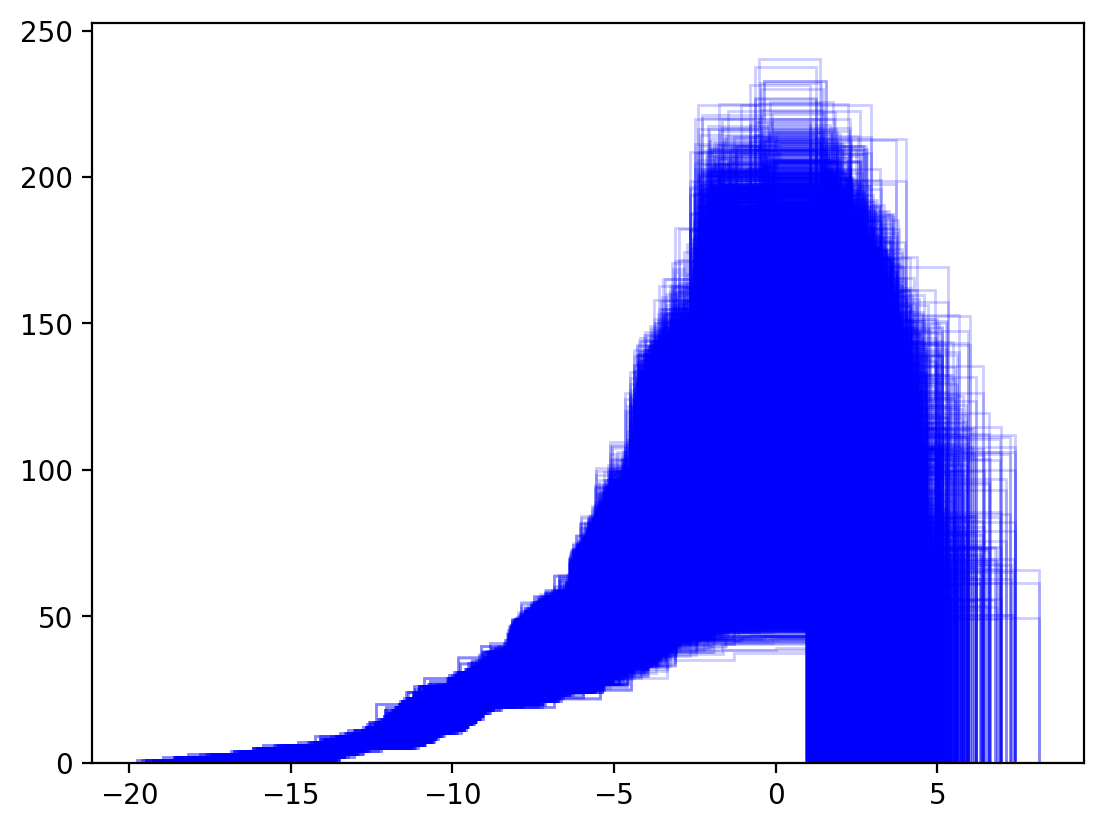

In [25]:
all_counts = []
all_counts_lsst = []
all_counts_lsst_subtracted = []
detected_counts_lsst = {'idealized': [], 'measured': [], 'measured_high_sig': []}
detected_counts_lsst_subtracted = {'idealized': [], 'measured': [], 'measured_high_sig': []}
cnts = {'idealized': [], 'measured': [], 'measured_high_sig': []}
nbins = 10
all_counts = []
mags = []
for alpha, sigma_M, M50, B, sigma_mpeak, A, sigma_r, n in samples_all[np.random.randint(len(samples_all),
                                                                                           size=1000)]:
    param_vector = [alpha,sigma_M,M50,sigma_mpeak,B,A,sigma_r,n,5.5]
    combined_satellite_properties_list, mock_counts = satellite_realization(param_vector,
                                                           hparams,cosmo_params,orphan_params,
                                                           halo_data,sim_indices,
                                                           vpeak_Mr_interp,masks,ssfs,'cdm')
    for i in range(len(combined_satellite_properties_list)):
        # ind = (combined_satellite_properties_list[i]['Mr']<100)
        ind = (combined_satellite_properties_list[i]['Mr']<0.) & (combined_satellite_properties_list[i]['r12']>10) ### CUTS
        l, b = celToGal(combined_satellite_properties_list[i]['ra'],combined_satellite_properties_list[i]['dec'])
        dec_cut = (-65.<combined_satellite_properties_list[i]['dec']) & (combined_satellite_properties_list[i]['dec']<15.)
        lsst_footprint = (np.abs(b)>20.) & (dec_cut)
        ###
        all_counts.append(np.sum(combined_satellite_properties_list[i]['prob'][ind]))
        ###
        all_counts_lsst.append(np.sum(combined_satellite_properties_list[i]['prob'][(ind) & (lsst_footprint)]))
        ###
        not_det = combined_satellite_properties_list[i]['pdet'] < 0.5
        all_counts_lsst_subtracted.append(np.sum(combined_satellite_properties_list[i]['prob'][(ind) & (lsst_footprint) & (not_det)]))
        ###
        D = combined_satellite_properties_list[i]['radii']
        Mv = combined_satellite_properties_list[i]['Mr'] + 0.2
        r12 = combined_satellite_properties_list[i]['r12']
        mags.extend(Mv)
        pdet = {'idealized': [], 'measured': [], 'measured_high_sig': []}
        ###
        for scenario in ['idealized', 'measured', 'measured_high_sig']:
            x_eval = np.vstack([Mv, np.log10(r12), D]).T
            mag_mask = Mv < -8.8
            pdet[scenario] = classifier[scenario].predict_proba(x_eval)[:,1]
            pdet[scenario] *= (ind*lsst_footprint)
            pdet[scenario][mag_mask] = 1.
            detected_counts_lsst[scenario].append(np.sum((combined_satellite_properties_list[i]['prob']*pdet[scenario])[(ind) & (lsst_footprint)]))
            detected_counts_lsst_subtracted[scenario].append(np.sum((combined_satellite_properties_list[i]['prob']*pdet[scenario])[(ind) & (lsst_footprint) & (not_det)]))
            counts, bins, _ = plt.hist(Mv, histtype='step', bins=nbins, weights=pdet[scenario], cumulative=1, color='blue', alpha=0.2)
            cnts[scenario].append(counts)

In [26]:
bin_counts = [[] for _ in range(nbins)]
for i in range(nbins):
    for lst in cnts['idealized']:
        bin_counts[i].append(lst[i])

high95 = [np.percentile(x, 97.5) for x in bin_counts]
low95 = [np.percentile(x, 2.5) for x in bin_counts]

high68 = [np.percentile(x, 84) for x in bin_counts]
low68 = [np.percentile(x, 16) for x in bin_counts]

std = np.array([np.std(x) for x in bin_counts])
mean = np.array([np.mean(x) for x in bin_counts])

med = [np.percentile(x, 50) for x in bin_counts]
scat = np.sqrt(med)

bin_counts = [[] for _ in range(nbins)]
for i in range(nbins):
    for lst in cnts['measured']:
        bin_counts[i].append(lst[i])

measured_med = [np.percentile(x, 50) for x in bin_counts]

bin_counts = [[] for _ in range(nbins)]
for i in range(nbins):
    for lst in cnts['measured_high_sig']:
        bin_counts[i].append(lst[i])

mhs = [np.percentile(x, 50) for x in bin_counts]


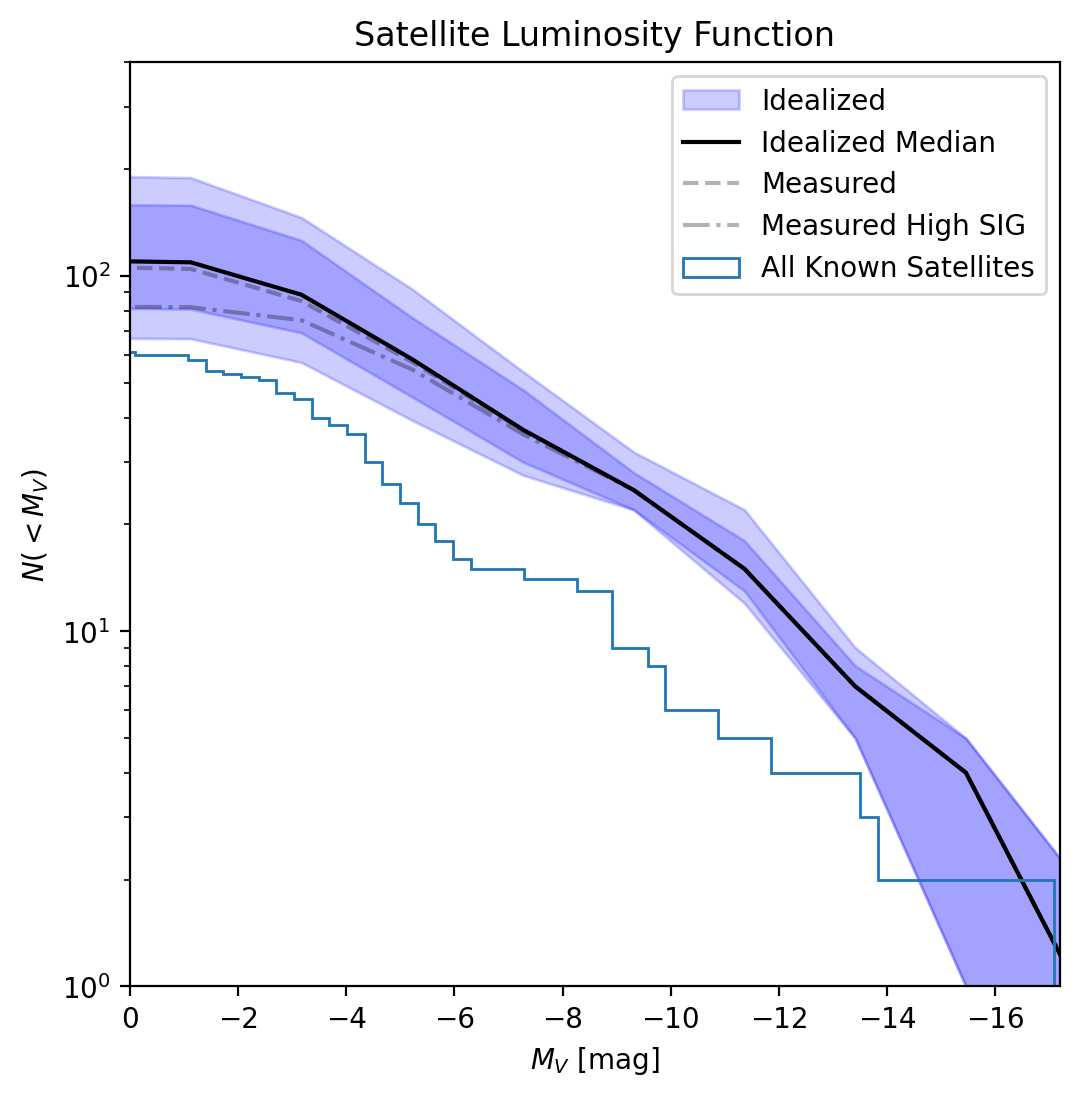

In [27]:
plt.figure(figsize=(6,6))
plt.xlim(-17.2, 0)
plt.ylim(1, 400)
plt.fill_between(bins[:-1], high95, low95, alpha=0.2, color='b', label='Idealized')
plt.fill_between(bins[:-1], high68, low68, alpha=0.2, color='b')
plt.plot(bins[:-1], med, linestyle='solid', color='black', label='Idealized Median')
plt.plot(bins[:-1], measured_med, linestyle='dashed', color='black', alpha=0.3, label='Measured')
plt.plot(bins[:-1], mhs, linestyle='dashdot', color='black', alpha=0.3, label='Measured High SIG')
plt.hist(confirmed_systems['M_V'], bins=62, histtype='step', cumulative=1, label='All Known Satellites')
plt.xlabel(r'$M_V$ [mag]')
plt.ylabel(r'$N(<M_V)$')
plt.yscale('log')
plt.gca().invert_xaxis()
plt.legend()
plt.title('Satellite Luminosity Function')
plt.savefig('luminosity_function.pdf')
plt.show()

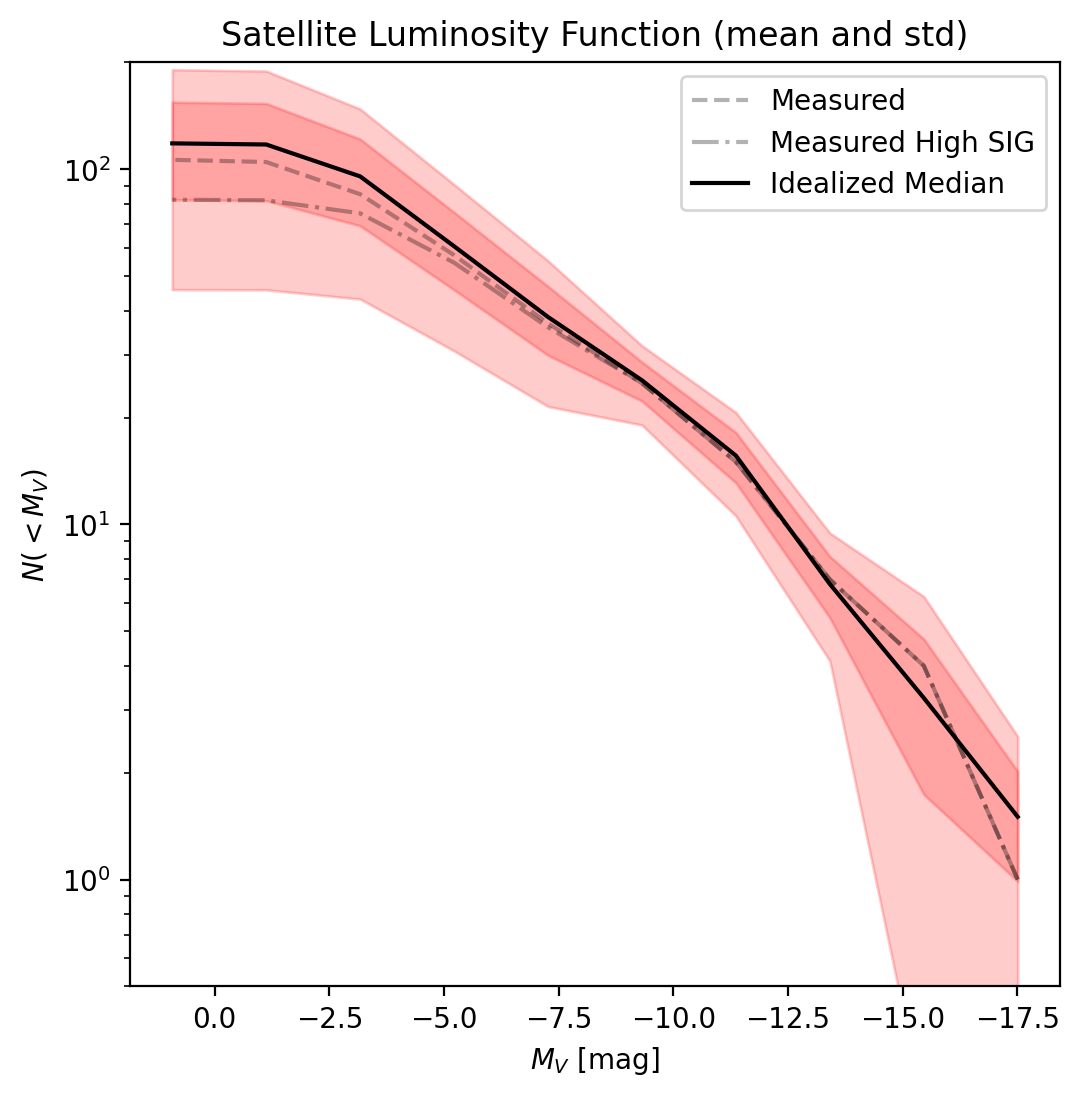

In [28]:
plt.figure(figsize=(6,6))
plt.plot(bins[:-1], measured_med, linestyle='dashed', color='black', alpha=0.3, label='Measured')
plt.plot(bins[:-1], mhs, linestyle='dashdot', color='black', alpha=0.3, label='Measured High SIG')
plt.plot(bins[:-1], mean, linestyle='solid', color='black', label='Idealized Median')
plt.fill_between(bins[:-1], mean-std, mean+std, alpha=0.2, color='r')
plt.fill_between(bins[:-1], mean-2*std, mean+2*std, alpha=0.2, color='r')
plt.xlabel(r'$M_V$ [mag]')
plt.ylabel(r'$N(<M_V)$')
plt.yscale('log')
plt.gca().invert_xaxis()
plt.ylim(0.5,200)
plt.legend()
plt.title('Satellite Luminosity Function (mean and std)')
plt.show()

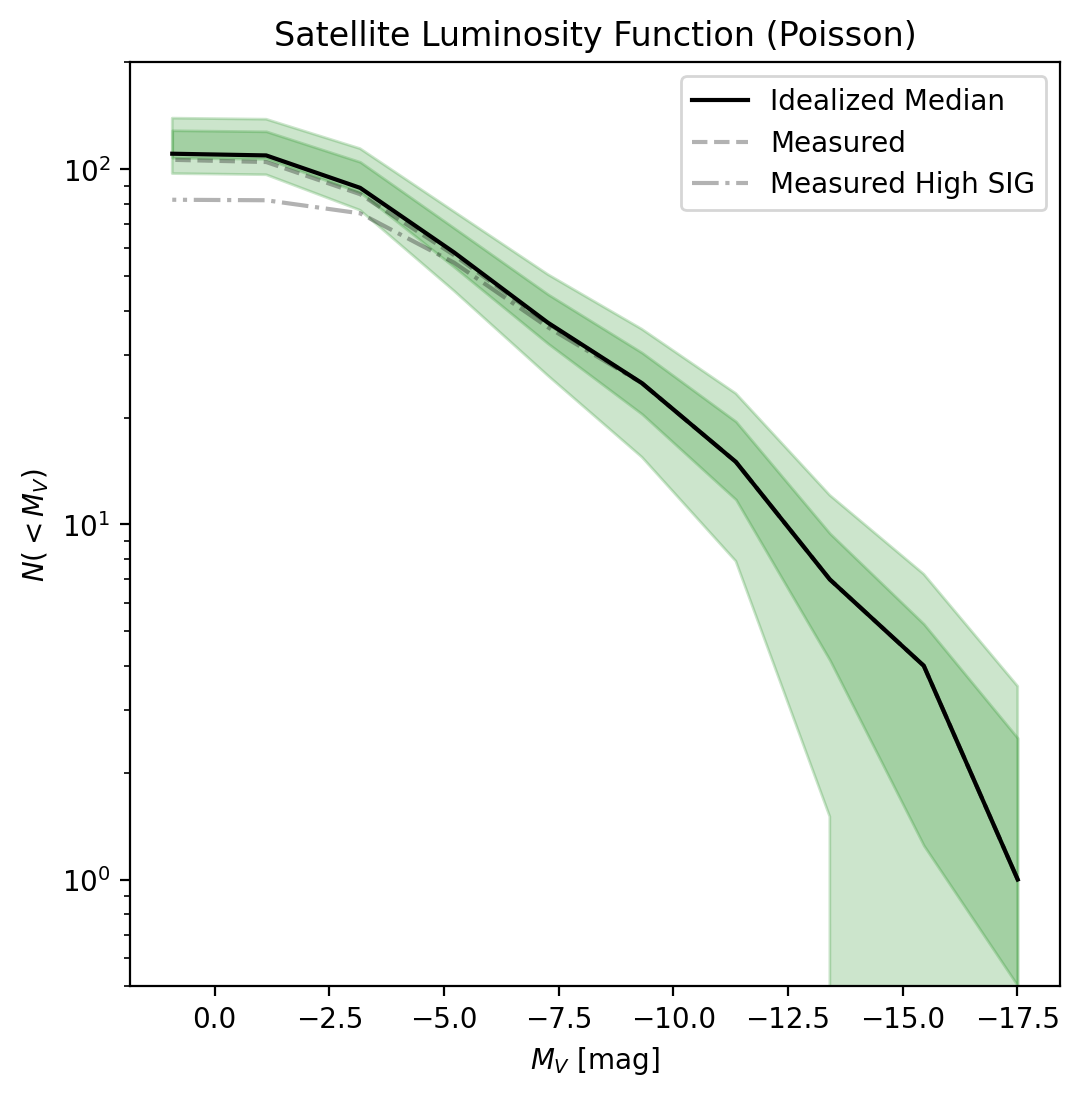

In [29]:
plt.figure(figsize=(6,6))
plt.plot(bins[:-1], med, linestyle='solid', color='black', label='Idealized Median')
plt.plot(bins[:-1], measured_med, linestyle='dashed', color='black', alpha=0.3, label='Measured')
plt.plot(bins[:-1], mhs, linestyle='dashdot', color='black', alpha=0.3, label='Measured High SIG')
plt.fill_between(bins[:-1], mean-scat, mean+scat, alpha=0.2, color='g')
plt.fill_between(bins[:-1], mean-2*scat, mean+2*scat, alpha=0.2, color='g')
plt.xlabel(r'$M_V$ [mag]')
plt.ylabel(r'$N(<M_V)$')
plt.yscale('log')
plt.gca().invert_xaxis()
plt.ylim(0.5,200)
plt.legend()
plt.title('Satellite Luminosity Function (Poisson)')
plt.show()

In [30]:
print(np.mean(all_counts),np.std(all_counts))
print(np.mean(all_counts_lsst),np.std(all_counts_lsst))
print(np.mean(detected_counts_lsst['idealized']),np.std(detected_counts_lsst['idealized']))
print(np.mean(detected_counts_lsst['measured']),np.std(detected_counts_lsst['measured']))
print(np.mean(detected_counts_lsst['measured_high_sig']),np.std(detected_counts_lsst['measured_high_sig']))

229.1406889782561 50.86907844982655
92.20938724655247 32.318740028004164
64.02317427793544 20.87187086086372
61.06696953896276 19.446468815950688
44.84687238651945 13.599674423858277


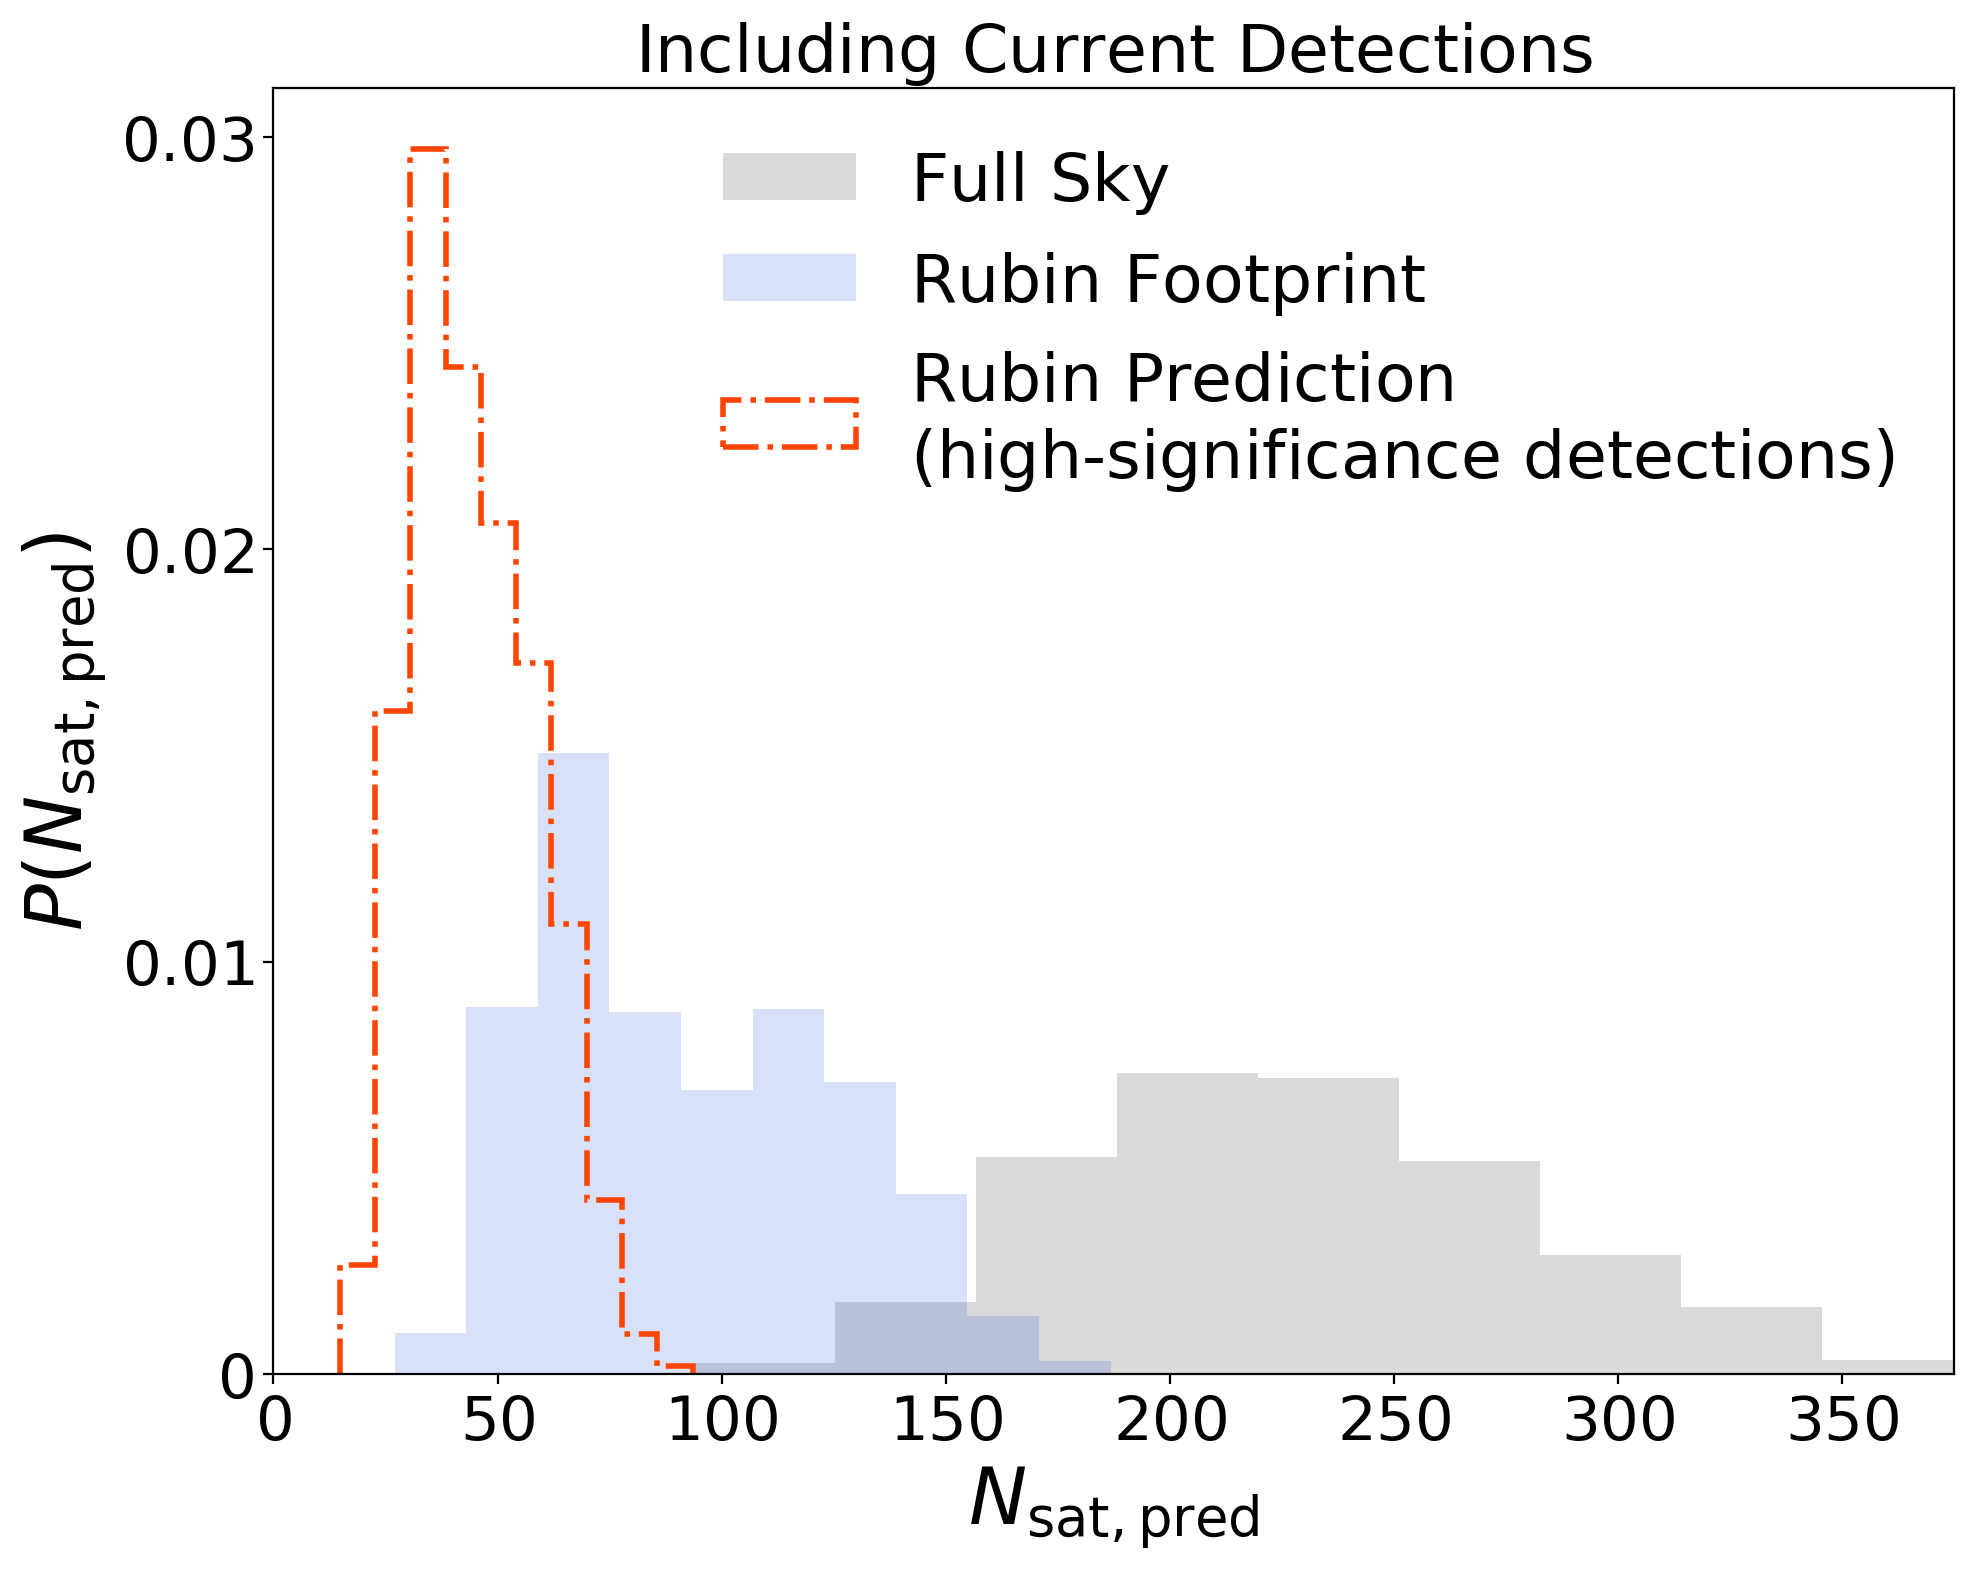

In [31]:
plt.figure(figsize=(10,8))

plt.hist(all_counts,density=True,alpha=0.15,color='k',label=r'$\mathrm{Full\ Sky}$')
plt.hist(all_counts_lsst,density=True,histtype='stepfilled',alpha=0.2,color='royalblue',label=r'$\mathrm{Rubin\ Footprint}$')
plt.hist(detected_counts_lsst['measured_high_sig'],density=True,histtype='step',lw=2,ls='-.',color='orangered',label=r'$\mathrm{Rubin\ Prediction}$'+'\n'+r'$\mathrm{(high}$-$\mathrm{significance\ detections)}$')

plt.xlim(0,375)

plt.xticks([0,50,100,150,200,250,300,350],[r'$0$',r'$50$',r'$100$',r'$150$',r'$200$',r'$250$',
                                          r'$300$',r'$350$'],fontsize=22)
plt.yticks([0,0.01,0.02,0.03],[r'$0$',r'$0.01$',r'$0.02$',r'$0.03$',],fontsize=22)

plt.xlabel(r'$N_{\mathrm{sat,pred}}$',fontsize=28)
plt.ylabel(r'$P(N_{\mathrm{sat,pred}})$',fontsize=28)
plt.legend(loc=1,fontsize=24,frameon=False)

plt.title(r'$\mathrm{Including\ Current\ Detections}$',fontsize=24)

plt.tight_layout()
plt.show()

In [32]:
print(np.mean(all_counts),np.std(all_counts))
print(np.mean(all_counts_lsst_subtracted),np.std(all_counts_lsst_subtracted))
print(np.mean(detected_counts_lsst_subtracted['idealized']),np.std(detected_counts_lsst_subtracted['idealized']))
print(np.mean(detected_counts_lsst_subtracted['measured']),np.std(detected_counts_lsst_subtracted['measured']))
print(np.mean(detected_counts_lsst_subtracted['measured_high_sig']),np.std(detected_counts_lsst_subtracted['measured_high_sig']))

229.1406889782561 50.86907844982655
76.35050889916185 28.53927440929968
48.25240012245978 16.544289388027394
45.46184070678423 15.211111836151014
29.26555840153558 9.296169425882242


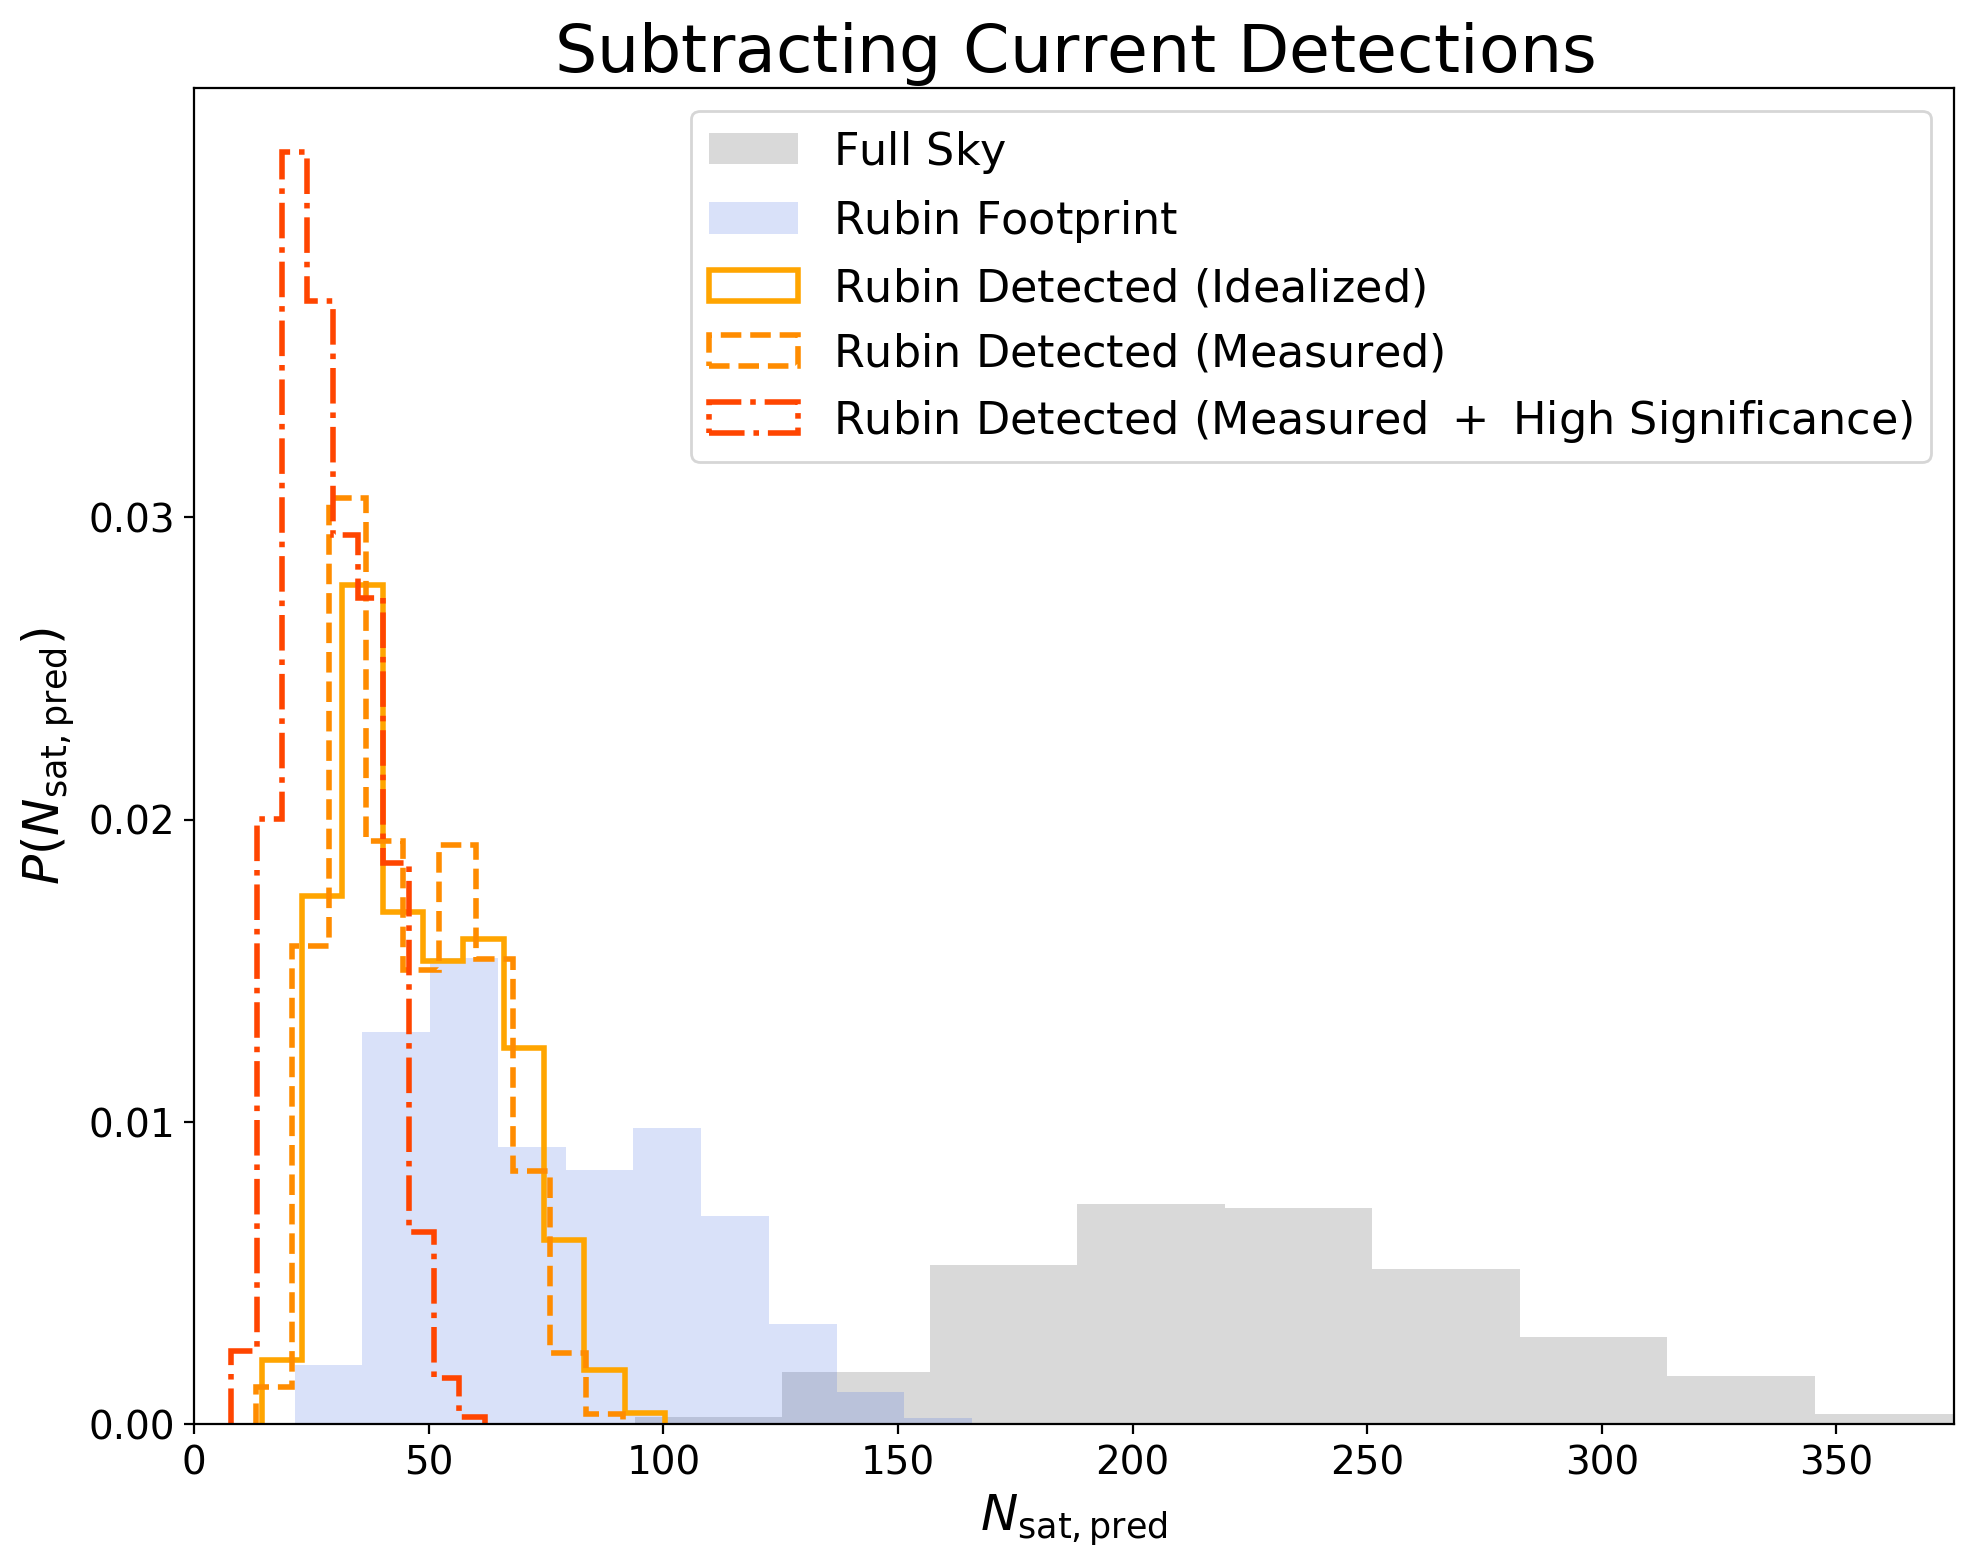

In [33]:
plt.figure(figsize=(10,8))

plt.hist(all_counts,density=True,alpha=0.15,color='k',label=r'$\mathrm{Full\ Sky}$')
plt.hist(all_counts_lsst_subtracted,density=True,histtype='stepfilled',alpha=0.2,color='royalblue',label=r'$\mathrm{Rubin\ Footprint}$')
plt.hist(detected_counts_lsst_subtracted['idealized'],density=True,histtype='step',lw=2,color='orange',label=r'$\mathrm{Rubin\ Detected\ (Idealized)}$')
plt.hist(detected_counts_lsst_subtracted['measured'],density=True,histtype='step',lw=2,ls='--',color='darkorange',label=r'$\mathrm{Rubin\ Detected\ (Measured)}$')
plt.hist(detected_counts_lsst_subtracted['measured_high_sig'],density=True,histtype='step',lw=2,ls='-.',color='orangered',label=r'$\mathrm{Rubin\ Detected\ (Measured\ +\ High\ Significance)}$')

plt.xlim(0,375)

plt.xticks([0,50,100,150,200,250,300,350],fontsize=14)
plt.yticks([0,0.01,0.02,0.03],fontsize=14)

plt.xlabel(r'$N_{\mathrm{sat,pred}}$',fontsize=18)
plt.ylabel(r'$P(N_{\mathrm{sat,pred}})$',fontsize=18)
plt.legend(loc=1,fontsize=16)

plt.title(r'$\mathrm{Subtracting\ Current\ Detections}$',fontsize=24)

plt.tight_layout()
plt.show()

# Detected LSST satellite properties

In [39]:
D, Mv, r12 = [], [], []
for alpha, sigma_M, M50, B, sigma_mpeak, A, sigma_r, n in samples_all[np.random.randint(len(samples_all),
                                                                                           size=1000)]:
    param_vector = [alpha,sigma_M,M50,sigma_mpeak,B,A,sigma_r,n,5.5]
    combined_satellite_properties_list, mock_counts = satellite_realization(param_vector,
                                                           hparams,cosmo_params,orphan_params,
                                                           halo_data,sim_indices,
                                                           vpeak_Mr_interp,masks,ssfs,'cdm') # This returns 2 Milky Way like halos, 5 observer locations each
    # ind = (combined_satellite_properties_list[i]['Mr']<100)
    ind = (combined_satellite_properties_list[0]['Mr']<100.)# & (combined_satellite_properties_list[0]['r12']>10) ### CUTS
    l, b = celToGal(combined_satellite_properties_list[0]['ra'],combined_satellite_properties_list[0]['dec'])
    dec_cut = (-65.<combined_satellite_properties_list[0]['dec']) & (combined_satellite_properties_list[0]['dec']<15.)
    lsst_footprint = (np.abs(b)>20.) & (dec_cut)
    not_det = combined_satellite_properties_list[0]['pdet'] < 0.5
    ###
    D.extend(combined_satellite_properties_list[0]['radii'][(ind) & (lsst_footprint) & (not_det)])
    Mv.extend(combined_satellite_properties_list[0]['Mr'][(ind) & (lsst_footprint) & (not_det)] + 0.2)
    r12.extend(combined_satellite_properties_list[0]['r12'][(ind) & (lsst_footprint) & (not_det)])

In [40]:
x_eval = np.vstack([Mv, np.log10(r12), D]).T
pdet = classifier['idealized'].predict_proba(x_eval)[:,1]
H, r12_edges, Mv_edges = np.histogram2d(r12, Mv, weights=pdet)

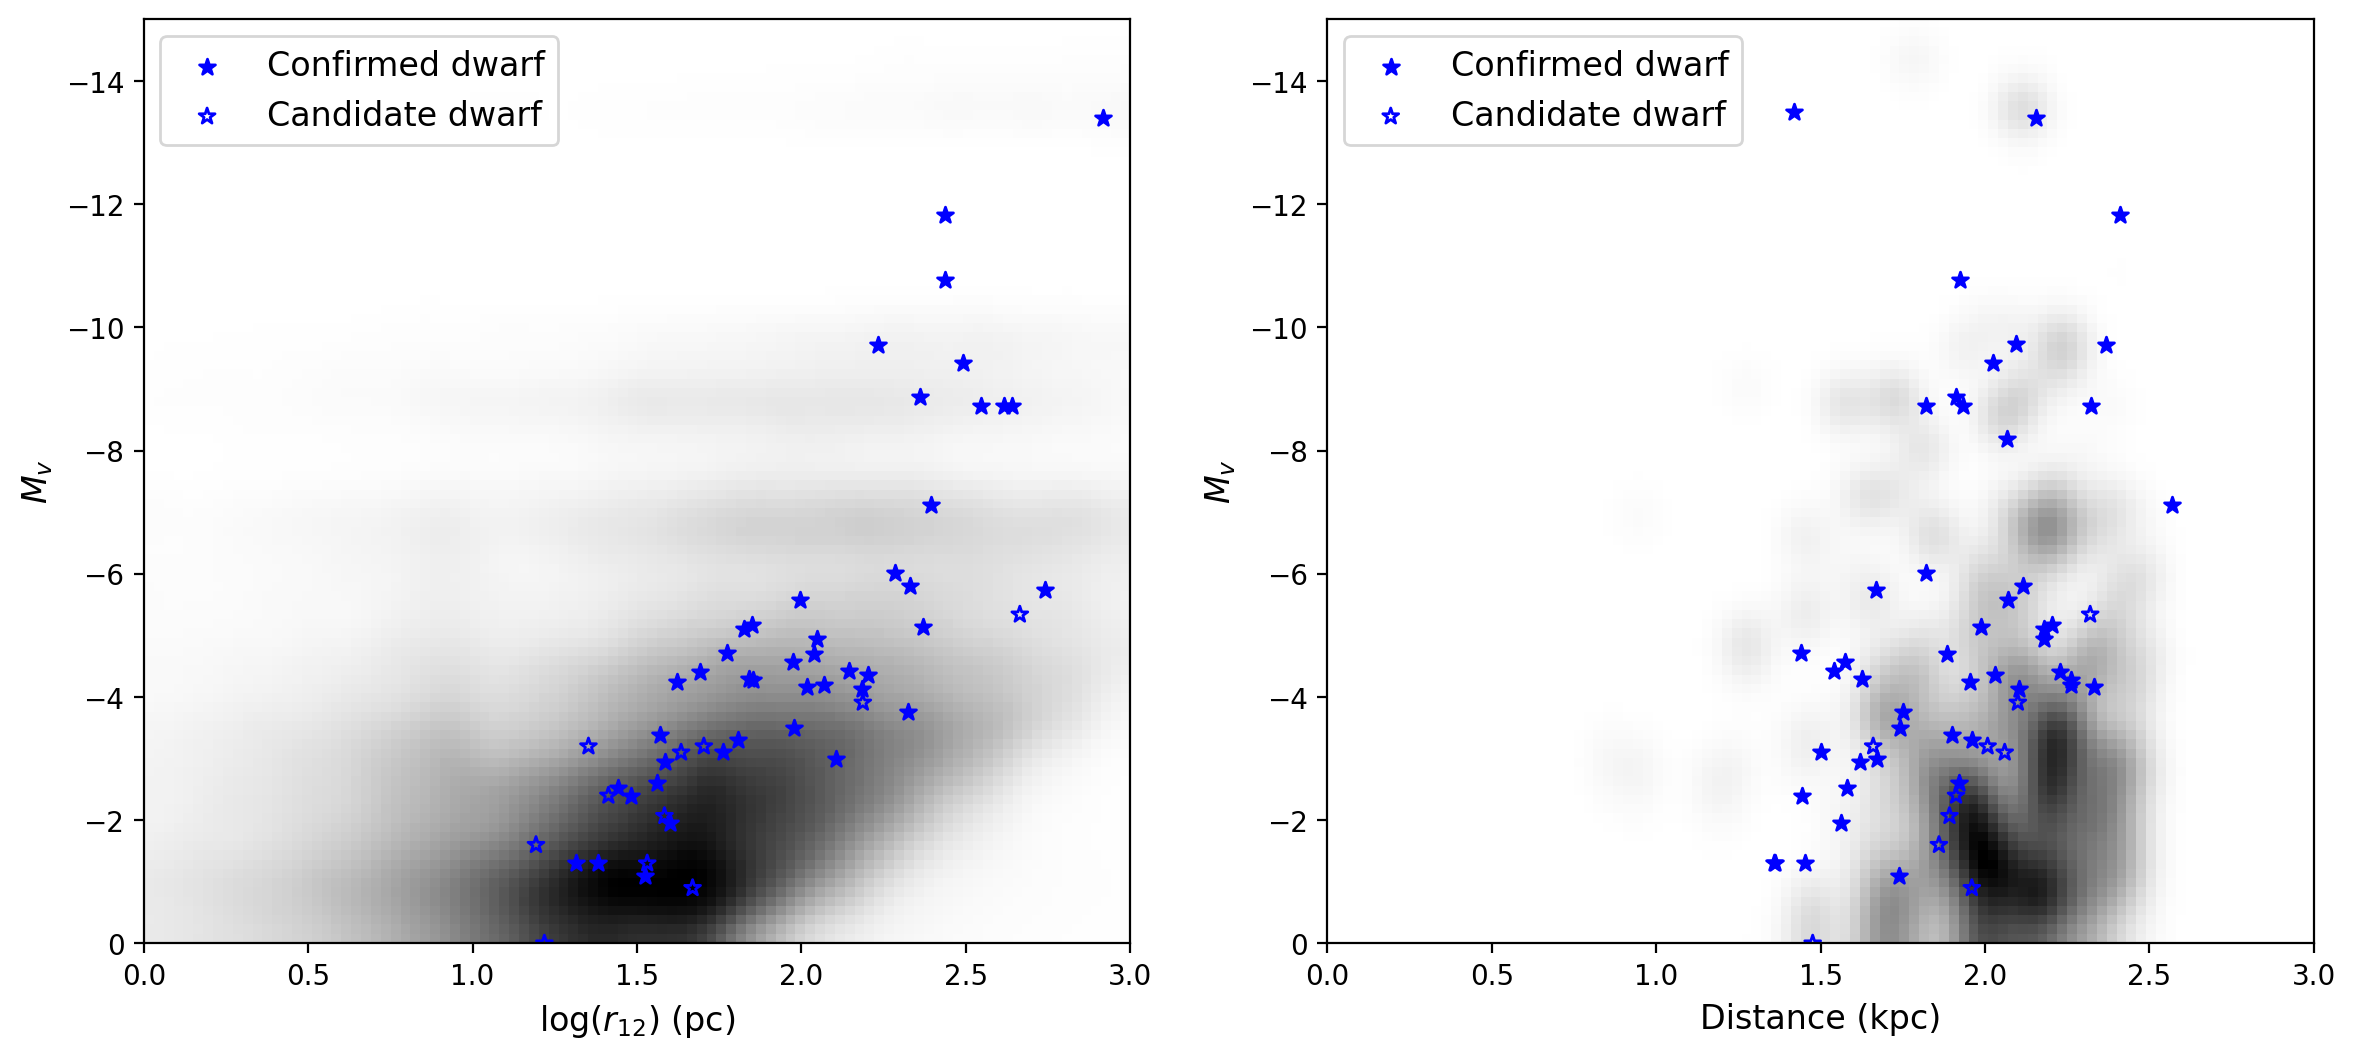

In [41]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
# Smoothing the data for the plot on the right
hist, xedges, yedges = np.histogram2d(np.log10(r12), Mv, bins=100, range=([0, 3], [-15, 0]), weights=pdet)
hist_smoothed = gaussian_filter(hist, sigma=2)

im = axs[0].imshow(hist_smoothed.T, origin='lower', aspect='auto', cmap='gray_r', 
                   extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])

# axs[0].hist2d(np.log10(r12), Mv, bins=100, range=([0, 3], [-15, 0]), cmap='gray_r', weights=pdet, edgecolor='face')

axs[0].scatter(np.log10(confirmed_dwarfs.rhalf_physical), confirmed_dwarfs.M_V, 
               marker='*', label='Confirmed dwarf', color='blue')
axs[0].scatter(np.log10(candidate_dwarfs.rhalf_physical), candidate_dwarfs.M_V,
               marker='*', label='Candidate dwarf', facecolors='none', edgecolors='blue')

axs[0].set_xlim([0, 3])
axs[0].set_ylim([-15, 0])
axs[0].invert_yaxis()
axs[0].set_xlabel(r'log($r_{12}$) (pc)', fontsize='large')
axs[0].set_ylabel(r'$M_v$', fontsize='large')
axs[0].legend(loc='upper left', bbox_to_anchor=(0, 1), fontsize='large')

# Smoothing the data for the plot on the right
hist, xedges, yedges = np.histogram2d(np.log10(D), Mv, bins=100, range=([0, 3], [-15, 0]), weights=pdet)
hist_smoothed = gaussian_filter(hist, sigma=2)

im = axs[1].imshow(hist_smoothed.T, origin='lower', aspect='auto', cmap='gray_r', 
                   extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])

axs[1].scatter(np.log10(confirmed_dwarfs.distance), confirmed_dwarfs.M_V,
               marker='*', label='Confirmed dwarf', color='blue')
axs[1].scatter(np.log10(candidate_dwarfs.distance), candidate_dwarfs.M_V,
               marker='*', label='Candidate dwarf', facecolors='none', edgecolors='blue')

axs[1].set_xlim([0, 3])
axs[1].set_ylim([-15, 0])
axs[1].invert_yaxis()
axs[1].set_xlabel('Distance (kpc)', fontsize='large')
axs[1].set_ylabel(r'$M_v$', fontsize='large')
axs[1].legend(loc='upper left', bbox_to_anchor=(0, 1), fontsize='large')

plt.savefig('dwarfs.pdf')
plt.show()

/tmp/ipykernel_15413/2883190522.py:11: RuntimeWarning: invalid value encountered in divide
  ratio_r12 = hist_weighted_r12 / hist_unweighted_r12
/tmp/ipykernel_15413/2883190522.py:12: RuntimeWarning: invalid value encountered in divide
  ratio_D = hist_weighted_D / hist_unweighted_D


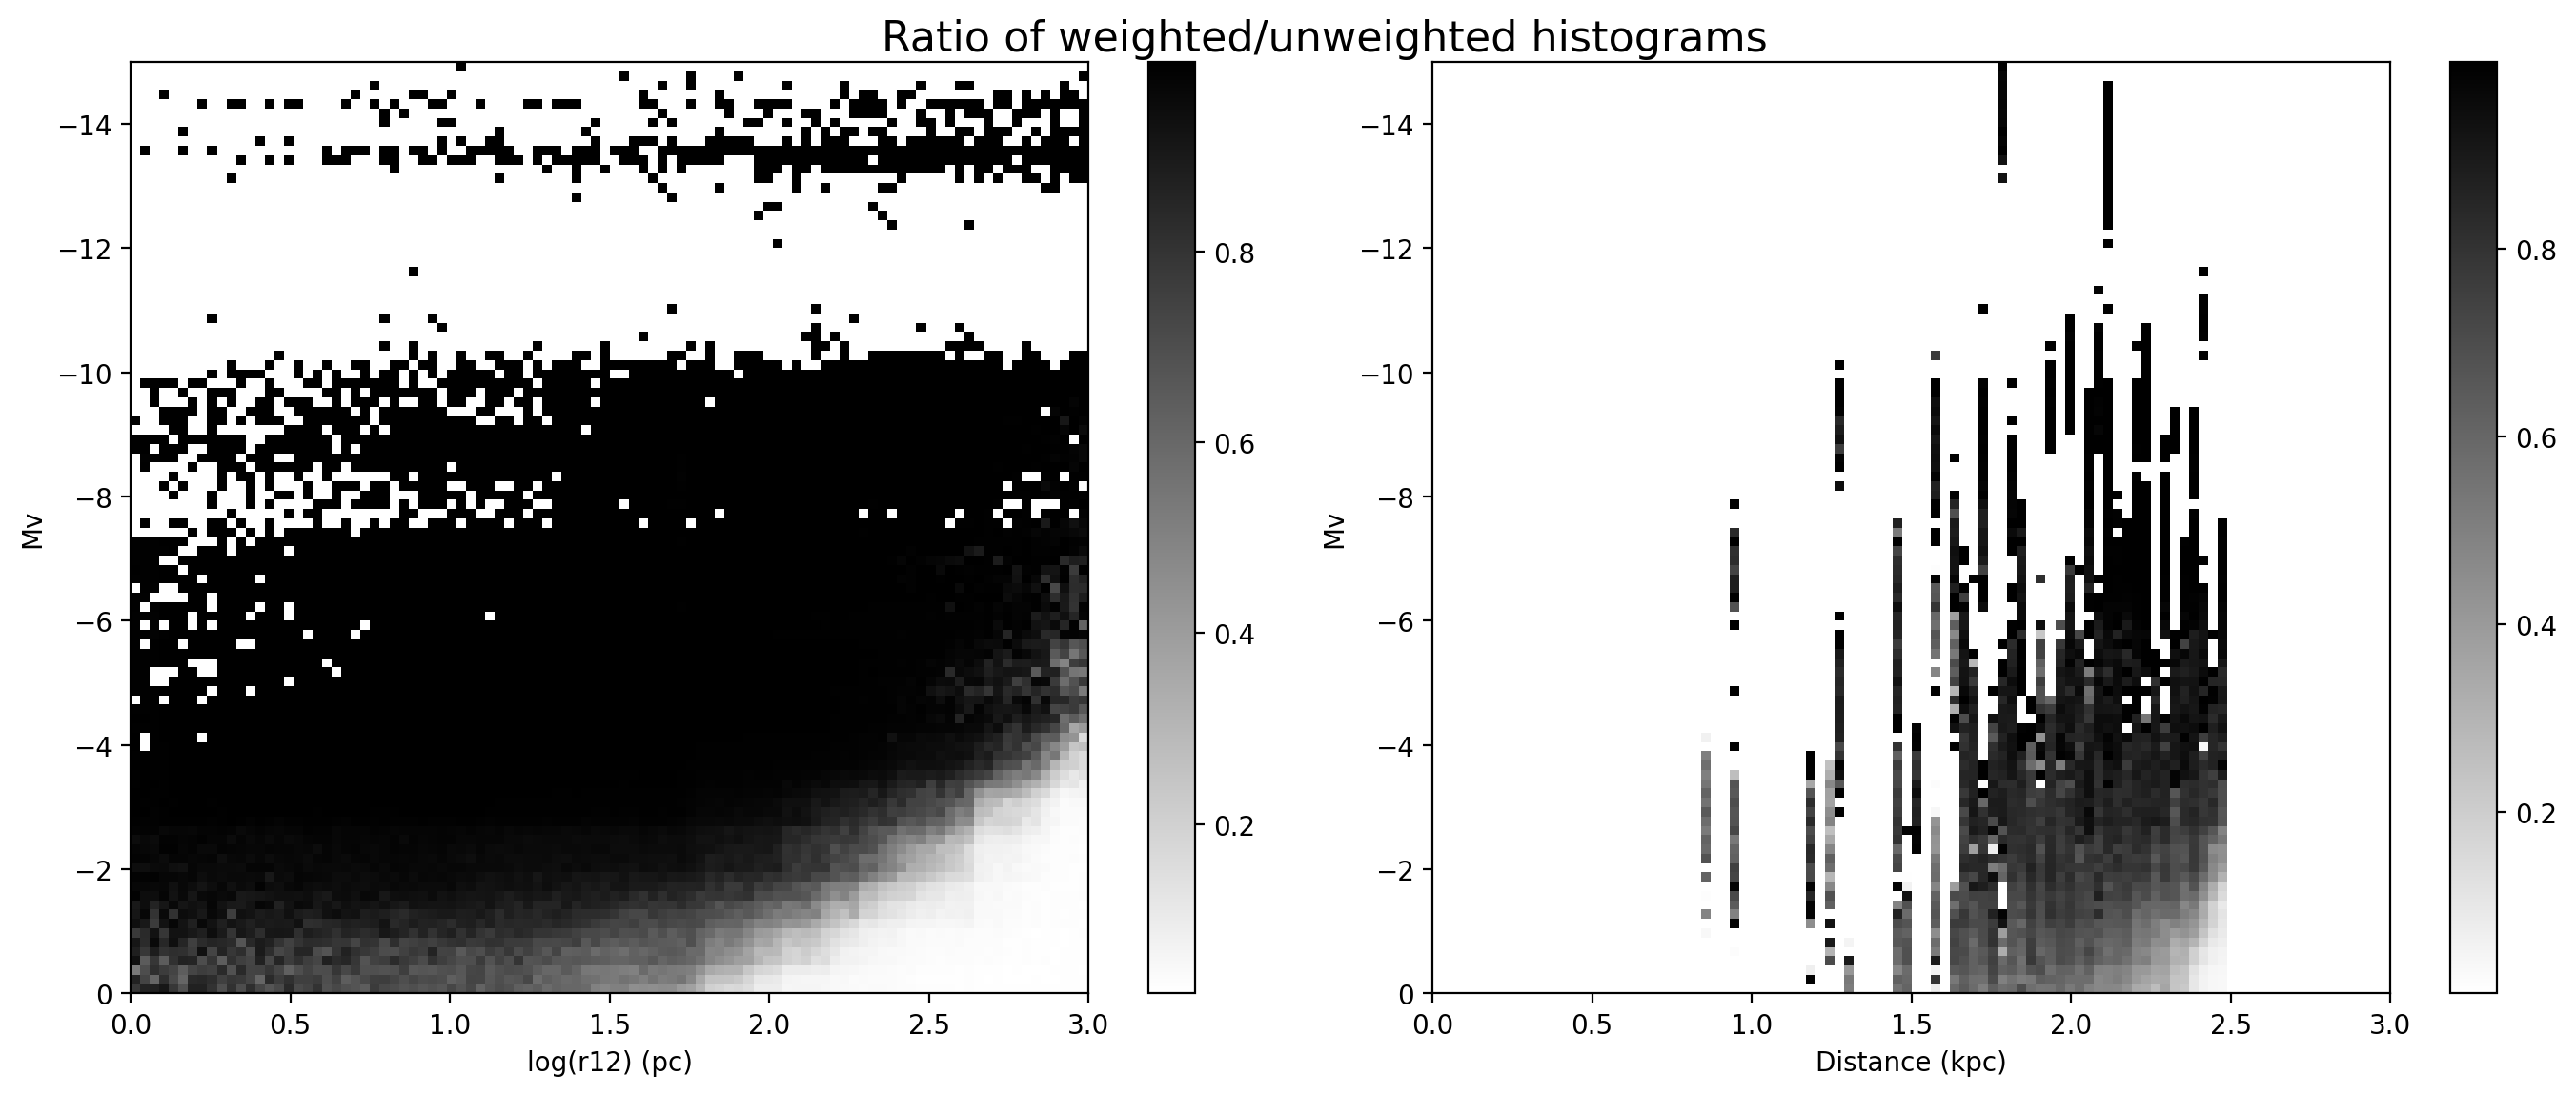

In [42]:
# Plotting the ratio of weighted/unweighted histograms
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

hist_weighted_r12, xedges, yedges = np.histogram2d(np.log10(r12), Mv, bins=100, range=([0, 3], [-15, 0]), weights=pdet)
hist_weighted_D, xedges, yedges = np.histogram2d(np.log10(D), Mv, bins=100, range=([0, 3], [-15, 0]), weights=pdet)

hist_unweighted_r12, xedges, yedges = np.histogram2d(np.log10(r12), Mv, bins=100, range=([0, 3], [-15, 0]))
hist_unweighted_D, xedges, yedges = np.histogram2d(np.log10(D), Mv, bins=100, range=([0, 3], [-15, 0]))

# Compute the ratio of weighted to unweighted histograms
ratio_r12 = hist_weighted_r12 / hist_unweighted_r12
ratio_D = hist_weighted_D / hist_unweighted_D

axs[0].pcolormesh(xedges, yedges, ratio_r12.T, cmap='gray_r')
axs[0].set_xlabel('log(r12) (pc)')
axs[0].set_ylabel('Mv')
axs[0].invert_yaxis()

axs[1].pcolormesh(xedges, yedges, ratio_D.T, cmap='gray_r')
axs[1].set_xlabel('Distance (kpc)')
axs[1].set_ylabel('Mv')
axs[1].invert_yaxis()

plt.colorbar(axs[0].pcolormesh(xedges, yedges, ratio_r12.T, cmap='gray_r'), ax=axs[0])
plt.colorbar(axs[1].pcolormesh(xedges, yedges, ratio_D.T, cmap='gray_r'), ax=axs[1])

fig.suptitle('Ratio of weighted/unweighted histograms', fontsize=16, y=0.95)
plt.tight_layout()
plt.show()